# SWB Regression Pipeline - HFA Power 
Created: 07/30/24 \
Updated: 08/22/2024 \
*ran with new regression dfs from 08/22/2024*

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp, pearsonr, spearmanr
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import re
import datetime
import scipy
import random
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.regression.mixed_linear_model import MixedLM 
from joblib import Parallel, delayed
import pickle
import itertools
import time 
from matplotlib.ticker import StrMethodFormatter
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import matplotlib as mpl
from matplotlib import cm
import patsy
from statsmodels.api import OLS
from scipy import stats
from tqdm import tqdm
# from sklearn.linear_model import RANSACRegressor
# from sklearn.metrics import r2_score, mean_squared_error



import warnings
warnings.filterwarnings('ignore')




In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Specify root directory for un-archived data and results 
base_dir   = '/sc/arion/projects/guLab/Alie/SWB/'
anat_dir   = f'{base_dir}ephys_analysis/recon_labels/'
neural_dir = f'{base_dir}ephys_analysis/data/'
behav_dir  = f'{base_dir}swb_behav_models/data/behavior_preprocessed/'
save_dir   = f'{base_dir}ephys_analysis/results/regression_data/'
script_dir = '/hpc/users/finka03/swb_ephys_analysis/scripts/'

date = datetime.date.today().strftime('%m%d%Y')
print(date)

08222024


In [4]:
import sys
sys.path.append(f'{base_dir}ephys_analysis/LFPAnalysis/')

from LFPAnalysis import analysis_utils

sys.path.append(f'{script_dir}analysis_notebooks/')

from ieeg_tools import *
from plot_tools import *

In [5]:
subj_ids = list(pd.read_excel(f'{base_dir}ephys_analysis/subj_info/SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[0]).PatientID)
n_subj = len(subj_ids)
# subj_ids


In [6]:
bdi_list = pd.read_excel(f'{base_dir}ephys_analysis/subj_info/SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[3])
bdi_list = list(bdi_list.SWB_BDI)
subj_info_df = pd.DataFrame({'subj_id':subj_ids,'bdi':bdi_list})
subj_info_df



,subj_id,bdi
0,MS002,14
1,MS003,8
2,MS009,16
3,MS011,13
4,MS015,26
5,MS016,10
6,MS017,26
7,MS019,12
8,MS022,10
9,MS024,16


In [7]:
# #### set theme for all plots
# # %matplotlib inline
# # from matplotlib import rc
# # rc('text', usetex=False)

# sns.set_theme(style='ticks') 
# sns.set_context("poster")



In [8]:
# from matplotlib.colors import ListedColormap,LinearSegmentedColormap
# import matplotlib as mpl
# from matplotlib import cm


# # saez_cmap colors = org,yellow, sagegreen, darker green, blue, purple 

# # 671351
# saez_colors    = ['#ffb243','#FCE27C','#6a9752','#1d5d2a','#00467e','#561C46']
# saez_hex_cmap  = ListedColormap(saez_colors)
# saez_rgb       = [mpl.colors.to_rgb(hex) for hex in saez_colors]
# saez_full_cmap = LinearSegmentedColormap.from_list('saez_full_cmap',saez_rgb,N=10)
# #plot_palette = saez_linear_cmap.resampled(lutsize=30)
# expanded_cmap  = [mpl.colors.rgb2hex(saez_full_cmap(c)[:3]) for c in range(saez_full_cmap.N)]


# Load beta power data 

In [7]:
band = 'hfa' 
hfa_df = pd.read_csv(f'{save_dir}{band}_master_df.csv')
hfa_df.subj_id.unique()

array(['MS002', 'MS003', 'MS009', 'MS011', 'MS015', 'MS016', 'MS017',
       'MS019', 'MS022', 'MS024', 'MS025', 'MS026', 'MS027', 'MS028',
       'MS029', 'MS030', 'MS033', 'MS035', 'MS041', 'MS043', 'MS048',
       'MS050', 'DA8', 'DA023', 'DA026', 'DA037', 'DA039'], dtype=object)

In [8]:
roi_reref_labels_master_df = pd.read_csv(glob(f'{base_dir}ephys_analysis/results/roi_info/roi_reref_labels_master.csv')[0])
roi_reref_labels_master_df = roi_reref_labels_master_df.drop(columns=['Unnamed: 0'])




In [9]:
roi_reref_labels_master_df.roi.value_counts()

dmpfc            225
ofc              202
acc              193
sts              155
hpc              135
amy              113
dlpfc            107
temporal         105
vlpfc             82
ains              71
pins              60
thalamus          58
temporal pole     31
mcc               28
phg               25
motor             25
parietal          24
vmpfc             23
caudate            8
pcc                1
Name: roi, dtype: int64

In [10]:
# keep_rois = roi_reref_labels_master_df.roi.value_counts().index[
#     roi_reref_labels_master_df.roi.value_counts().values>=50].tolist()

keep_rois = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins','acc','amy','hpc']     
keep_rois


['dlpfc', 'vlpfc', 'dmpfc', 'ofc', 'ains', 'pins', 'acc', 'amy', 'hpc']

In [11]:
# ####### NEW DATA FRAME 
hfa_reg_df = hfa_df.copy()
hfa_reg_df = hfa_reg_df[hfa_reg_df.roi.isin(keep_rois)]

# Test Single Electrode Regressions 

In [12]:
elec_col    = 'unique_reref_ch'
main_var    = 'decisionCPE'
reg_formula = 'band_pow~GambleChoice+TotalProfit+decisionCPE'
n_permutations = 1000
results_dict, main_var_sig = run_individual_elec_regression(hfa_reg_df,reg_formula,elec_col, main_var,n_permutations)

Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 3365.31it/s]


In [13]:
save_vars = results_dict['MS002_lacas1-lacas2'].index.tolist()
save_vars


['Intercept', 'GambleChoice[T.safe]', 'TotalProfit', 'decisionCPE']

In [14]:
results = single_elec_permutation_results(results_dict,hfa_reg_df,save_vars)
results

,unique_elec_id,subj_id,roi,bdi,Original_Estimate_Intercept,Original_Estimate_GambleChoice[T.safe],Original_Estimate_TotalProfit,Original_Estimate_decisionCPE,Permuted_Mean_Intercept,Permuted_Mean_GambleChoice[T.safe],...,Permuted_Std_TotalProfit,Permuted_Std_decisionCPE,Z_Score_Intercept,Z_Score_GambleChoice[T.safe],Z_Score_TotalProfit,Z_Score_decisionCPE,P_Value_Intercept,P_Value_GambleChoice[T.safe],P_Value_TotalProfit,P_Value_decisionCPE
0,MS002_lacas1-lacas2,MS002,acc,14,0.009602,-0.019527,-0.024831,0.021213,-0.004010,0.000150,...,0.010603,0.010541,1.712564,-1.712564,-2.352623,2.022293,0.086793,0.086793,0.018642,0.043146
1,MS002_lacas2-lacas3,MS002,acc,14,0.013824,-0.026959,-0.020466,0.032208,-0.005278,0.000654,...,0.012343,0.012699,2.015319,-2.015319,-1.698843,2.534649,0.043871,0.043871,0.089349,0.011256
2,MS002_lacas3-lacas4,MS002,acc,14,0.018103,-0.030073,-0.034169,0.000575,-0.002673,-0.000041,...,0.012738,0.012412,2.176770,-2.176770,-2.697589,0.094518,0.029498,0.029498,0.006984,0.924698
3,MS002_lacas4-lacas5,MS002,acc,14,0.015891,-0.022747,-0.039756,0.001034,0.000300,-0.000211,...,0.014301,0.013759,1.472487,-1.472487,-2.822156,0.105560,0.140889,0.140889,0.004770,0.915932
4,MS002_lacas5-lacas6,MS002,acc,14,0.023452,-0.028664,-0.008658,-0.003695,0.003428,0.000281,...,0.012433,0.012468,2.191804,-2.191804,-0.729971,-0.324288,0.028394,0.028394,0.465408,0.745720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1183,DA039_rpins1-rpins2,DA039,pins,22,-0.000885,-0.018211,0.018350,0.001634,-0.007884,0.000047,...,0.017104,0.017352,0.995751,-0.995751,1.016034,0.119437,0.319371,0.319371,0.309613,0.904930
1184,DA039_rpins2-rpins3,DA039,pins,22,-0.000429,-0.038045,0.028140,-0.020577,-0.014687,-0.000849,...,0.026118,0.026537,1.417293,-1.417293,1.058086,-0.712082,0.156397,0.156397,0.290016,0.476414
1185,DA039_rpins3-rpins4,DA039,pins,22,0.001596,-0.051768,0.039688,-0.042583,-0.018488,0.000625,...,0.037573,0.039169,1.398840,-1.398840,1.025215,-1.049478,0.161861,0.161861,0.305262,0.293958
1186,DA039_rsgcc6-rsgcc7,DA039,vlpfc,22,-0.096861,0.042294,0.026198,0.028030,-0.080550,-0.000258,...,0.021313,0.021573,-1.859164,1.859164,1.266842,1.268597,0.063004,0.063004,0.205212,0.204585


In [15]:
# # create a binary pickle file 
pickle.dump(results,
            open(f'{save_dir}single_elec_regression_{band}_{reg_formula}_{date}.pkl',"wb"))

In [16]:
sig_data = results[results.unique_elec_id.isin(main_var_sig)]
sig_data

,unique_elec_id,subj_id,roi,bdi,Original_Estimate_Intercept,Original_Estimate_GambleChoice[T.safe],Original_Estimate_TotalProfit,Original_Estimate_decisionCPE,Permuted_Mean_Intercept,Permuted_Mean_GambleChoice[T.safe],...,Permuted_Std_TotalProfit,Permuted_Std_decisionCPE,Z_Score_Intercept,Z_Score_GambleChoice[T.safe],Z_Score_TotalProfit,Z_Score_decisionCPE,P_Value_Intercept,P_Value_GambleChoice[T.safe],P_Value_TotalProfit,P_Value_decisionCPE
0,MS002_lacas1-lacas2,MS002,acc,14,0.009602,-0.019527,-0.024831,0.021213,-0.004010,0.000150,...,0.010603,0.010541,1.712564,-1.712564,-2.352623,2.022293,0.086793,0.086793,0.018642,0.043146
1,MS002_lacas2-lacas3,MS002,acc,14,0.013824,-0.026959,-0.020466,0.032208,-0.005278,0.000654,...,0.012343,0.012699,2.015319,-2.015319,-1.698843,2.534649,0.043871,0.043871,0.089349,0.011256
40,MS002_lpips3-lpips4,MS002,pins,14,0.015306,-0.032655,-0.033791,-0.044934,-0.007318,0.000048,...,0.020938,0.019650,1.569295,-1.569295,-1.636897,-2.294223,0.116579,0.116579,0.101652,0.021778
51,MS002_racas6-racas7,MS002,dmpfc,14,0.021060,-0.002760,-0.027003,-0.028567,0.018993,0.000228,...,0.014039,0.013927,0.199088,-0.199088,-1.912545,-2.079027,0.842194,0.842194,0.055806,0.037615
52,MS002_racas7-racas8,MS002,dmpfc,14,0.023569,-0.002962,-0.018571,-0.031314,0.021229,0.000421,...,0.015044,0.014893,0.216786,-0.216786,-1.272477,-2.092713,0.828375,0.828375,0.203204,0.036375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1107,DA8_lam1-lam2,DA8,amy,13,-0.017245,0.009853,0.011285,0.021787,-0.010108,-0.000207,...,0.009861,0.010170,-0.879135,0.879135,1.086906,2.167918,0.379328,0.379328,0.277079,0.030165
1111,DA8_lhh1-lhh2,DA8,hpc,13,-0.019394,-0.005550,0.034642,-0.029674,-0.023593,0.000369,...,0.014362,0.014578,0.372238,-0.372238,2.480809,-2.083443,0.709716,0.709716,0.013108,0.037211
1145,DA037_rof1-rof2,DA037,ofc,4,-0.012610,0.001246,0.034839,0.060822,-0.012814,0.002112,...,0.024546,0.023985,0.030717,-0.030717,1.442951,2.570313,0.975495,0.975495,0.149034,0.010161
1152,DA037_rmc7-rmc8,DA037,dlpfc,4,-0.026976,0.074267,0.029557,-0.061234,-0.009737,0.001000,...,0.019911,0.020646,-3.017270,3.017270,1.448750,-2.953906,0.002551,0.002551,0.147407,0.003138


In [17]:
sig_data.roi.value_counts()

acc      31
ofc      23
dmpfc    17
ains     15
hpc      10
vlpfc     9
amy       8
dlpfc     6
pins      4
Name: roi, dtype: int64

In [18]:
sig_data.roi.unique()

array(['acc', 'pins', 'dmpfc', 'ains', 'ofc', 'vlpfc', 'hpc', 'amy',
       'dlpfc'], dtype=object)

In [19]:
bar_order = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins', 'acc','hpc','amy']


In [20]:
results.groupby('roi').agg('mean')['Z_Score_decisionCPE'][bar_order]

roi
dlpfc   -0.099494
vlpfc    0.176572
dmpfc    0.092376
ofc      0.578021
ains     0.218091
pins     0.149033
acc      0.474780
hpc      0.170288
amy      0.400467
Name: Z_Score_decisionCPE, dtype: float64

In [21]:
single_elec_res = results.copy()[results.roi.isin(bar_order)]
single_elec_res

,unique_elec_id,subj_id,roi,bdi,Original_Estimate_Intercept,Original_Estimate_GambleChoice[T.safe],Original_Estimate_TotalProfit,Original_Estimate_decisionCPE,Permuted_Mean_Intercept,Permuted_Mean_GambleChoice[T.safe],...,Permuted_Std_TotalProfit,Permuted_Std_decisionCPE,Z_Score_Intercept,Z_Score_GambleChoice[T.safe],Z_Score_TotalProfit,Z_Score_decisionCPE,P_Value_Intercept,P_Value_GambleChoice[T.safe],P_Value_TotalProfit,P_Value_decisionCPE
0,MS002_lacas1-lacas2,MS002,acc,14,0.009602,-0.019527,-0.024831,0.021213,-0.004010,0.000150,...,0.010603,0.010541,1.712564,-1.712564,-2.352623,2.022293,0.086793,0.086793,0.018642,0.043146
1,MS002_lacas2-lacas3,MS002,acc,14,0.013824,-0.026959,-0.020466,0.032208,-0.005278,0.000654,...,0.012343,0.012699,2.015319,-2.015319,-1.698843,2.534649,0.043871,0.043871,0.089349,0.011256
2,MS002_lacas3-lacas4,MS002,acc,14,0.018103,-0.030073,-0.034169,0.000575,-0.002673,-0.000041,...,0.012738,0.012412,2.176770,-2.176770,-2.697589,0.094518,0.029498,0.029498,0.006984,0.924698
3,MS002_lacas4-lacas5,MS002,acc,14,0.015891,-0.022747,-0.039756,0.001034,0.000300,-0.000211,...,0.014301,0.013759,1.472487,-1.472487,-2.822156,0.105560,0.140889,0.140889,0.004770,0.915932
4,MS002_lacas5-lacas6,MS002,acc,14,0.023452,-0.028664,-0.008658,-0.003695,0.003428,0.000281,...,0.012433,0.012468,2.191804,-2.191804,-0.729971,-0.324288,0.028394,0.028394,0.465408,0.745720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1183,DA039_rpins1-rpins2,DA039,pins,22,-0.000885,-0.018211,0.018350,0.001634,-0.007884,0.000047,...,0.017104,0.017352,0.995751,-0.995751,1.016034,0.119437,0.319371,0.319371,0.309613,0.904930
1184,DA039_rpins2-rpins3,DA039,pins,22,-0.000429,-0.038045,0.028140,-0.020577,-0.014687,-0.000849,...,0.026118,0.026537,1.417293,-1.417293,1.058086,-0.712082,0.156397,0.156397,0.290016,0.476414
1185,DA039_rpins3-rpins4,DA039,pins,22,0.001596,-0.051768,0.039688,-0.042583,-0.018488,0.000625,...,0.037573,0.039169,1.398840,-1.398840,1.025215,-1.049478,0.161861,0.161861,0.305262,0.293958
1186,DA039_rsgcc6-rsgcc7,DA039,vlpfc,22,-0.096861,0.042294,0.026198,0.028030,-0.080550,-0.000258,...,0.021313,0.021573,-1.859164,1.859164,1.266842,1.268597,0.063004,0.063004,0.205212,0.204585


In [22]:

single_rho_data = []
single_sig_rho = []

# BDI CORRELATIONS
for roi in single_elec_res.roi.unique().tolist():
    roi_temp_data = single_elec_res[single_elec_res.roi==roi]
    rho,rho_p     = pearsonr(roi_temp_data.bdi,roi_temp_data.Z_Score_decisionCPE)
#     rho,rho_p     = pearsonr(roi_temp_data.bdi,roi_temp_data.elec_bCPE)
#     print(f'{roi} pearsonr',rho,rho_p)
#     fe_results['rho'][fe_results.roi==roi]   = rho
#     fe_results['rho_p'][fe_results.roi==roi] = rho_p
    
    single_rho_data.append(pd.DataFrame({'roi':roi,'rho':rho,'rho_p':np.round(rho_p,4)},index=[0]))
#     if rho_p <= bonferr_alpha:
#         sig_bdi_rois.append(roi)
#     if rho_p < bonferr_alpha:
    if rho_p < 0.05:
        single_sig_rho.append((roi,rho,rho_p))
#     print(f'{roi} pearsonr',rho,rho_p)

single_rho_data = pd.concat(single_rho_data).reset_index(drop=True)

In [23]:
agg_single_results = single_elec_res.groupby('roi').agg('mean')[['Z_Score_decisionCPE']].copy()

agg_single_results


,Z_Score_decisionCPE
roi,
acc,0.474780
ains,0.218091
amy,0.400467
dlpfc,-0.099494
dmpfc,0.092376
hpc,0.170288
ofc,0.578021
pins,0.149033
vlpfc,0.176572


In [24]:
single_rho_data = single_rho_data.set_index('roi')
single_rho_data['Z_Score_decisionCPE'] = agg_single_results.Z_Score_decisionCPE
single_rho_data[['Z_Score_decisionCPE','rho','rho_p']]

,Z_Score_decisionCPE,rho,rho_p
roi,,,
acc,0.474780,-0.161808,0.0246
dmpfc,0.092376,-0.138826,0.0374
amy,0.400467,-0.288703,0.0019
ains,0.218091,-0.205291,0.0859
vlpfc,0.176572,-0.045431,0.6853
hpc,0.170288,-0.153294,0.0759
ofc,0.578021,0.041368,0.5589
pins,0.149033,-0.077852,0.5544
dlpfc,-0.099494,-0.029688,0.7615


In [25]:
ylabel = fr'$HFA_{{zpow}} \sim cpe$'
fig_save_dir = '/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/results/single-electrode-regressions/'
fig_id = f'{band}_single_elec_roi_barplot.pdf'


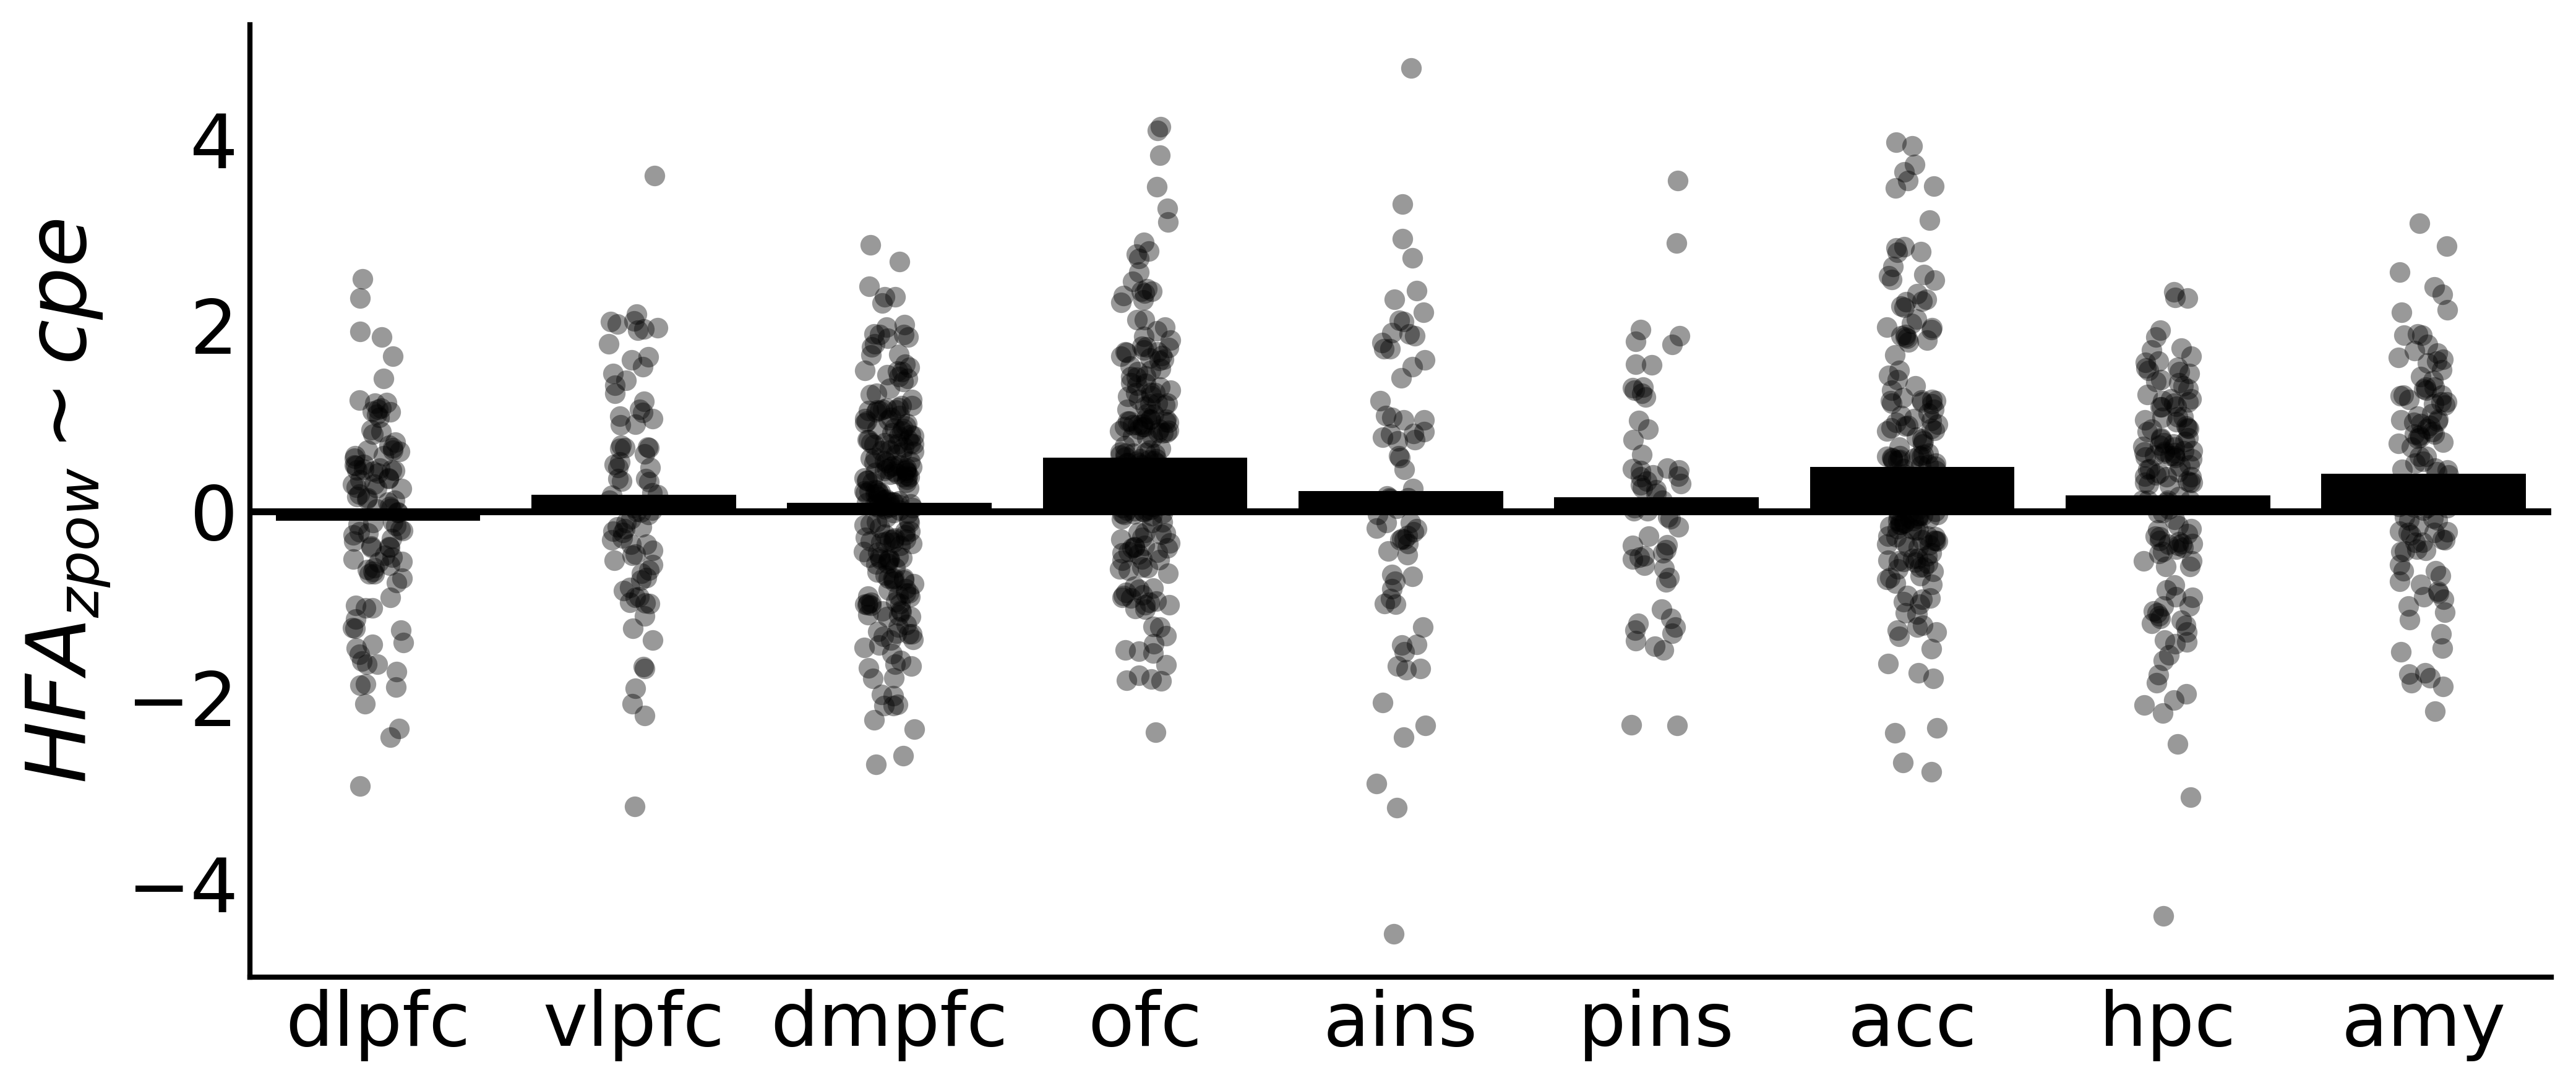

In [26]:
plot_roi_model_results(results,'roi','Z_Score_decisionCPE',bar_order=bar_order,figsize=(12,5),color='k',
                       ylabel=ylabel,save_fig=True,save_dir=fig_save_dir,fig_id=fig_id,dpi=400)


In [27]:
results.to_csv(f'{fig_save_dir}{band}_single_elec_perm_results.csv')

In [28]:
# plot_roi_model_results(results,'roi','Z_Score_decisionCPE',bar_order=bar_order,figsize=(13,4),color='k')
# green '#135546'


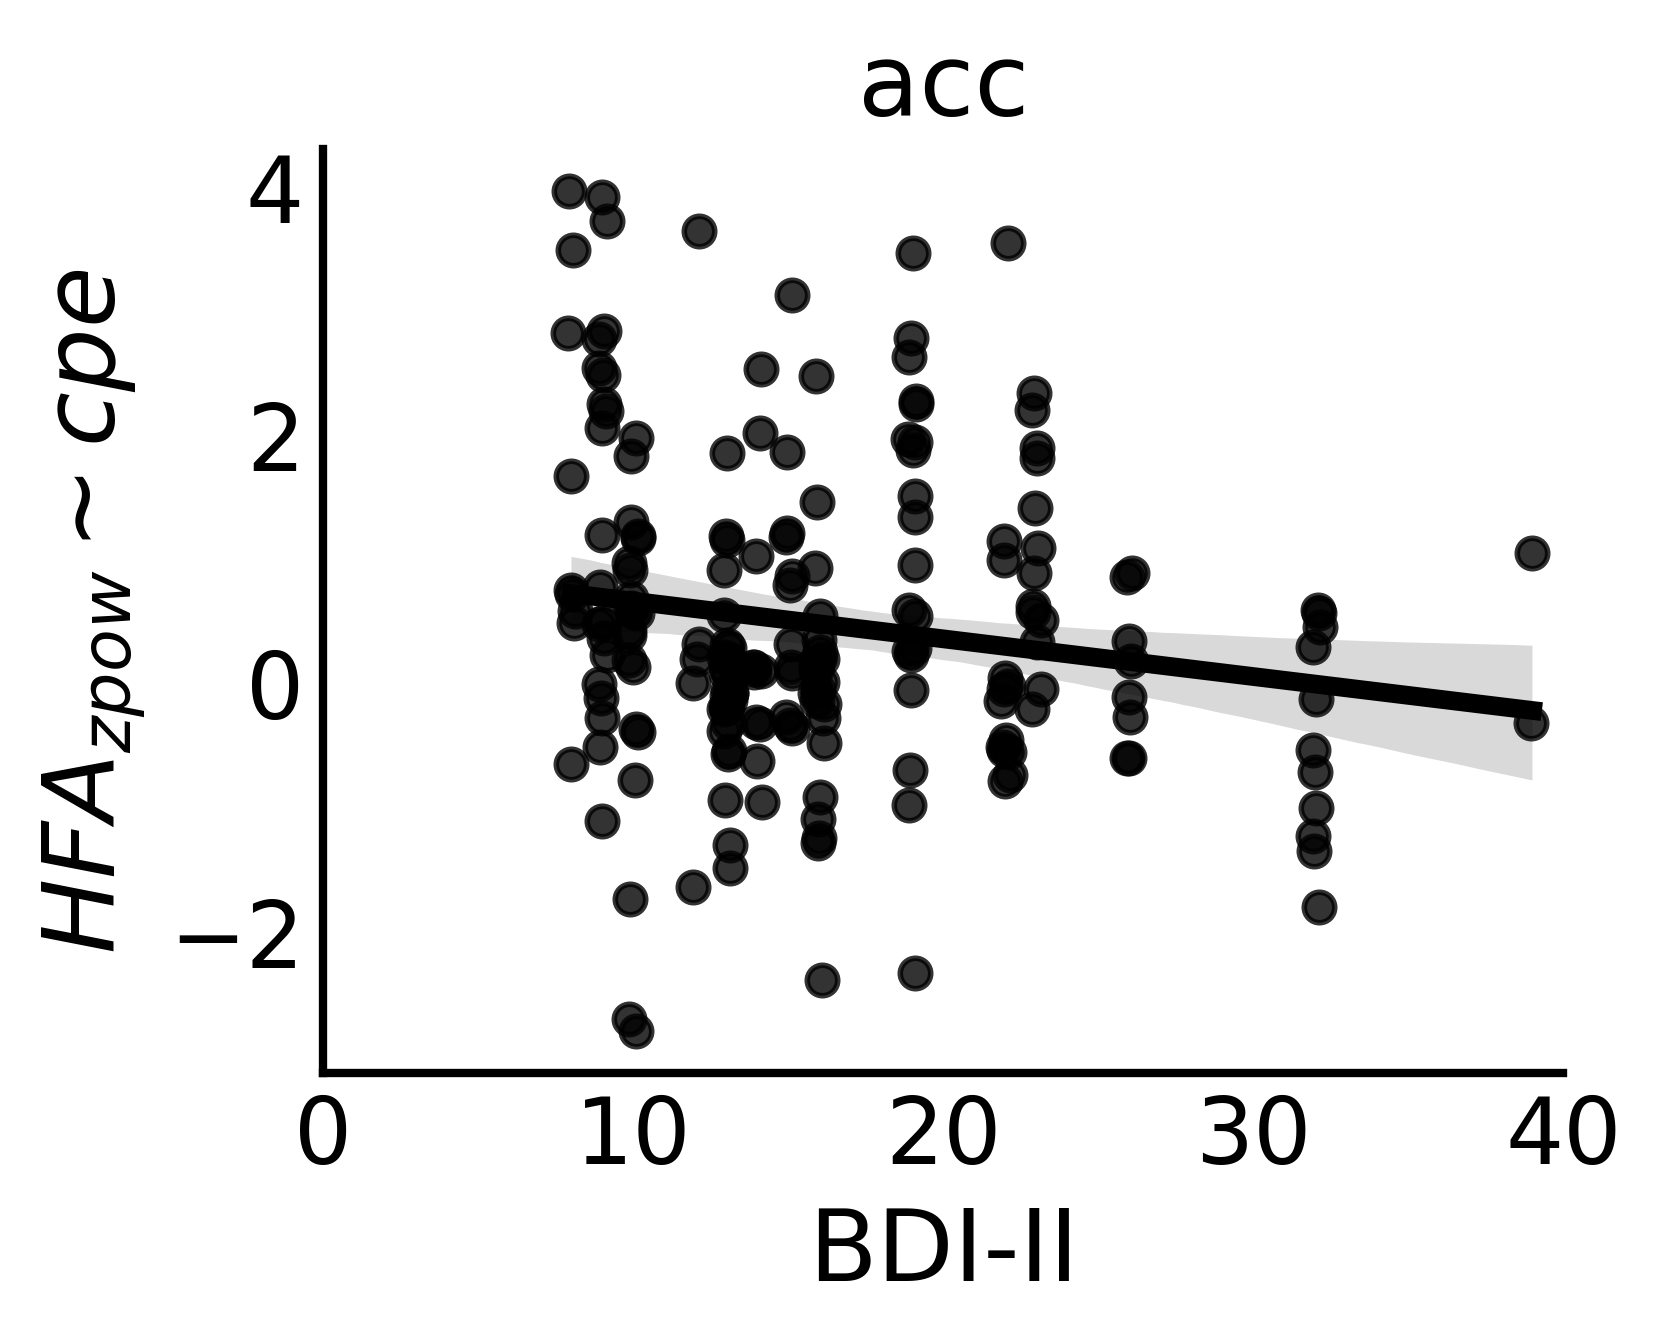

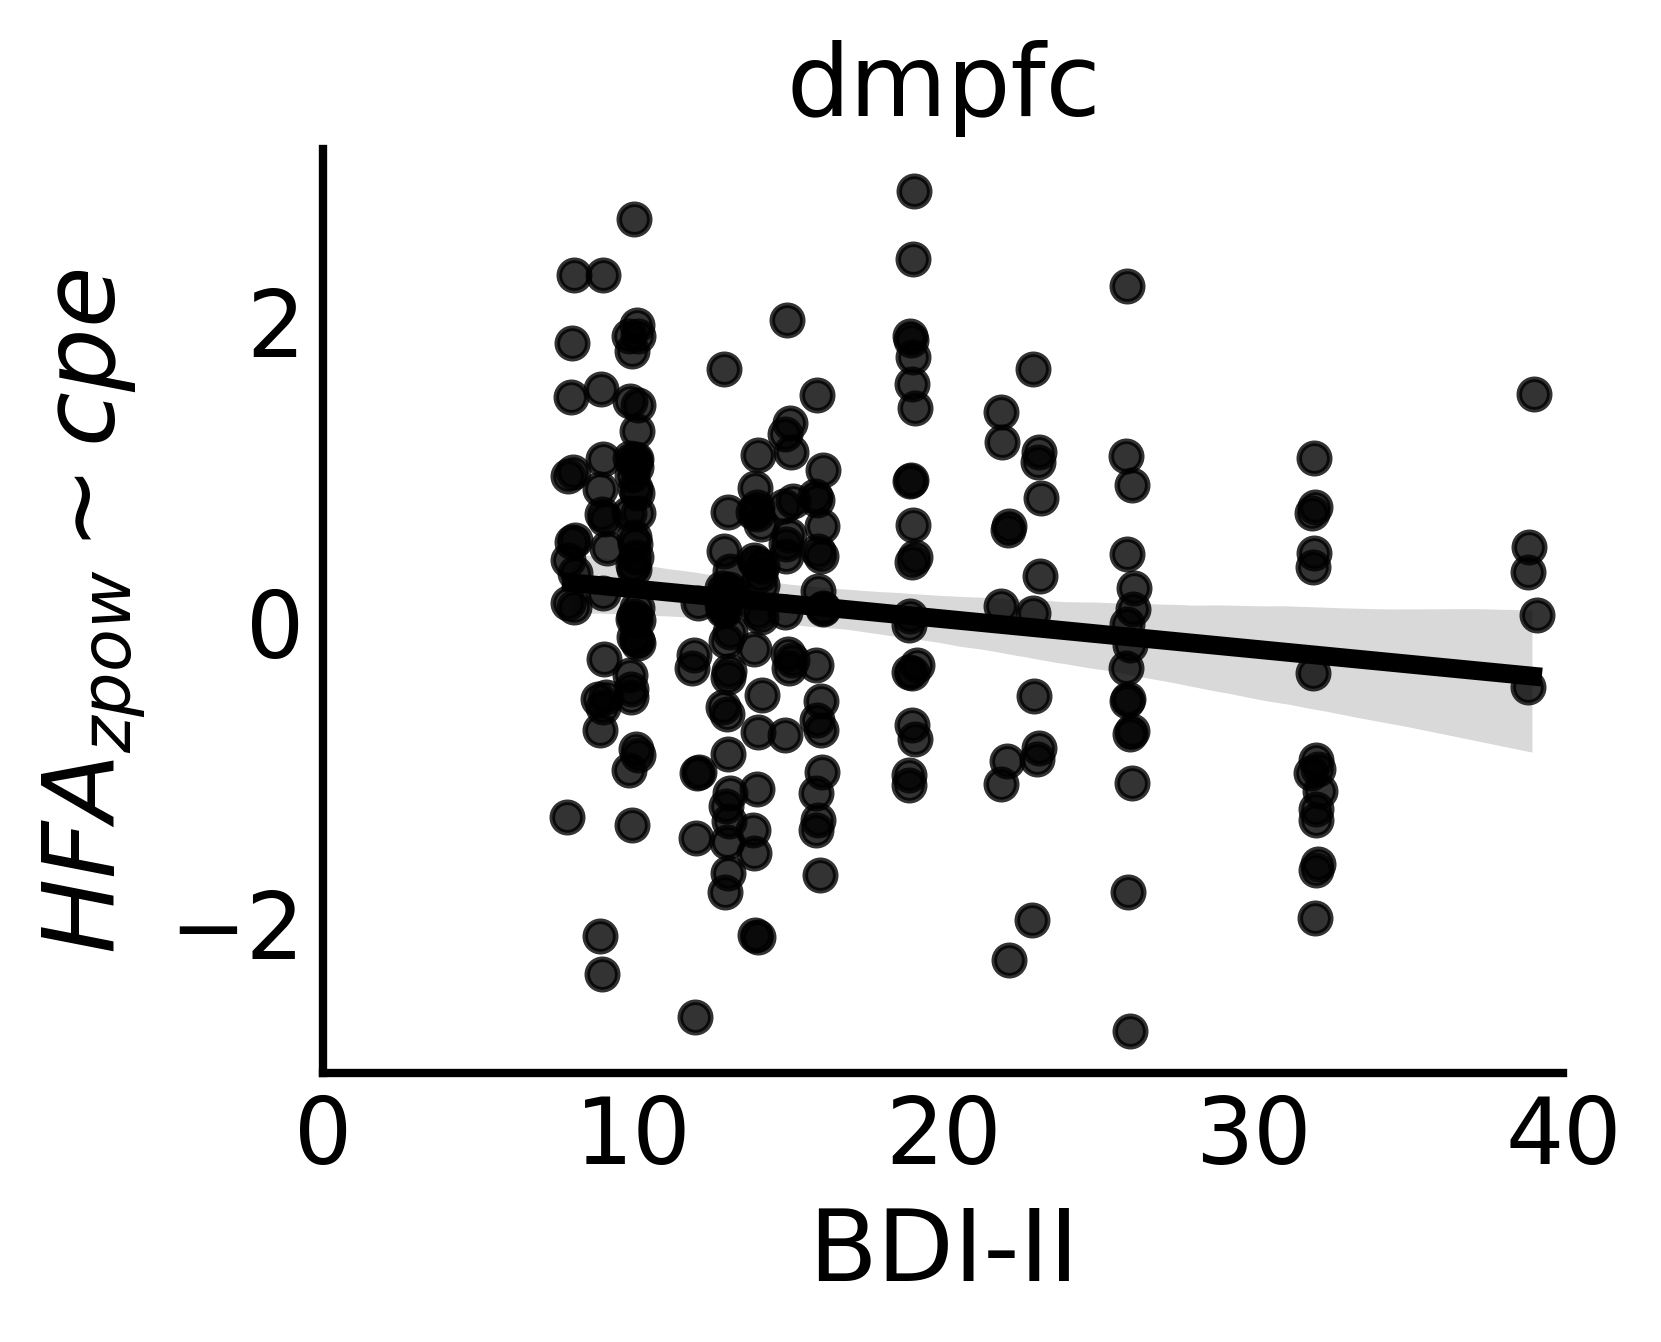

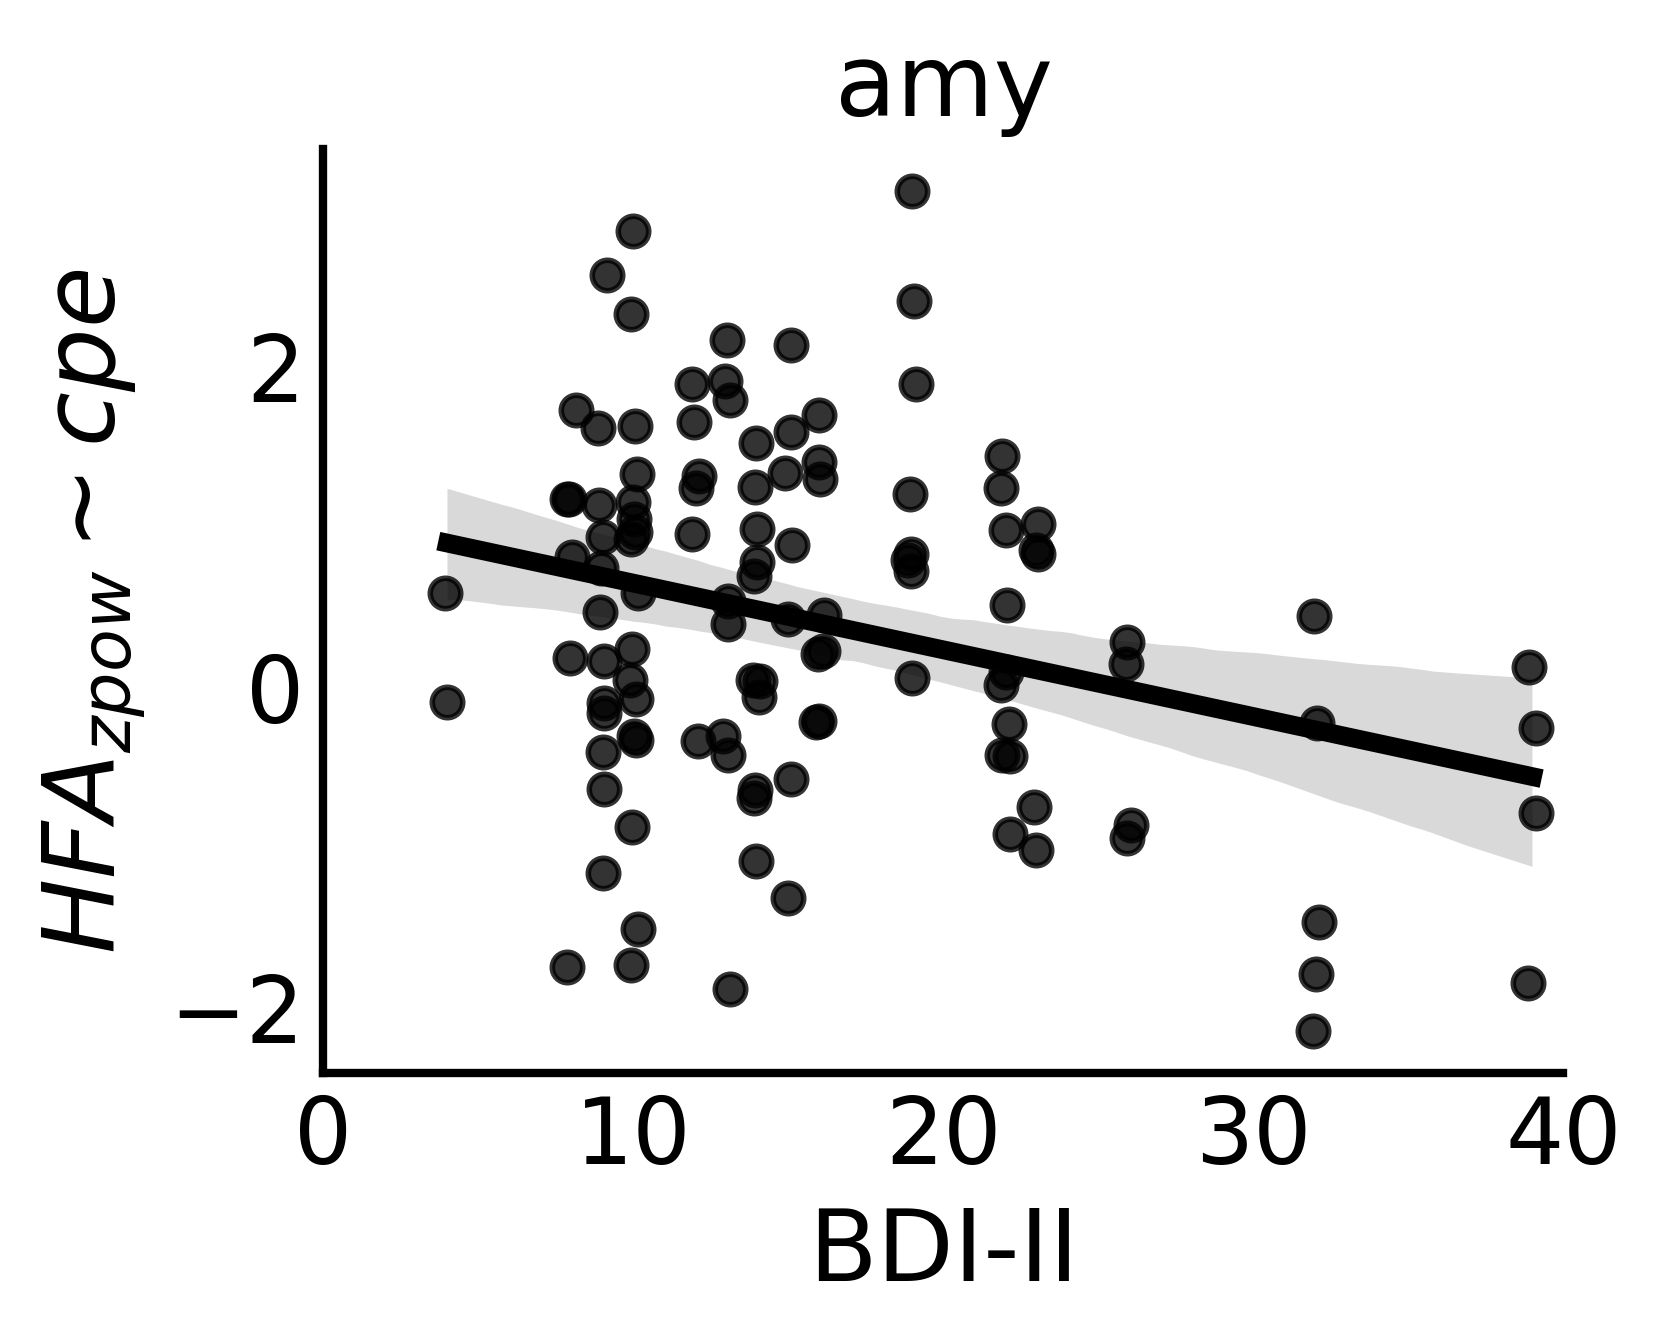

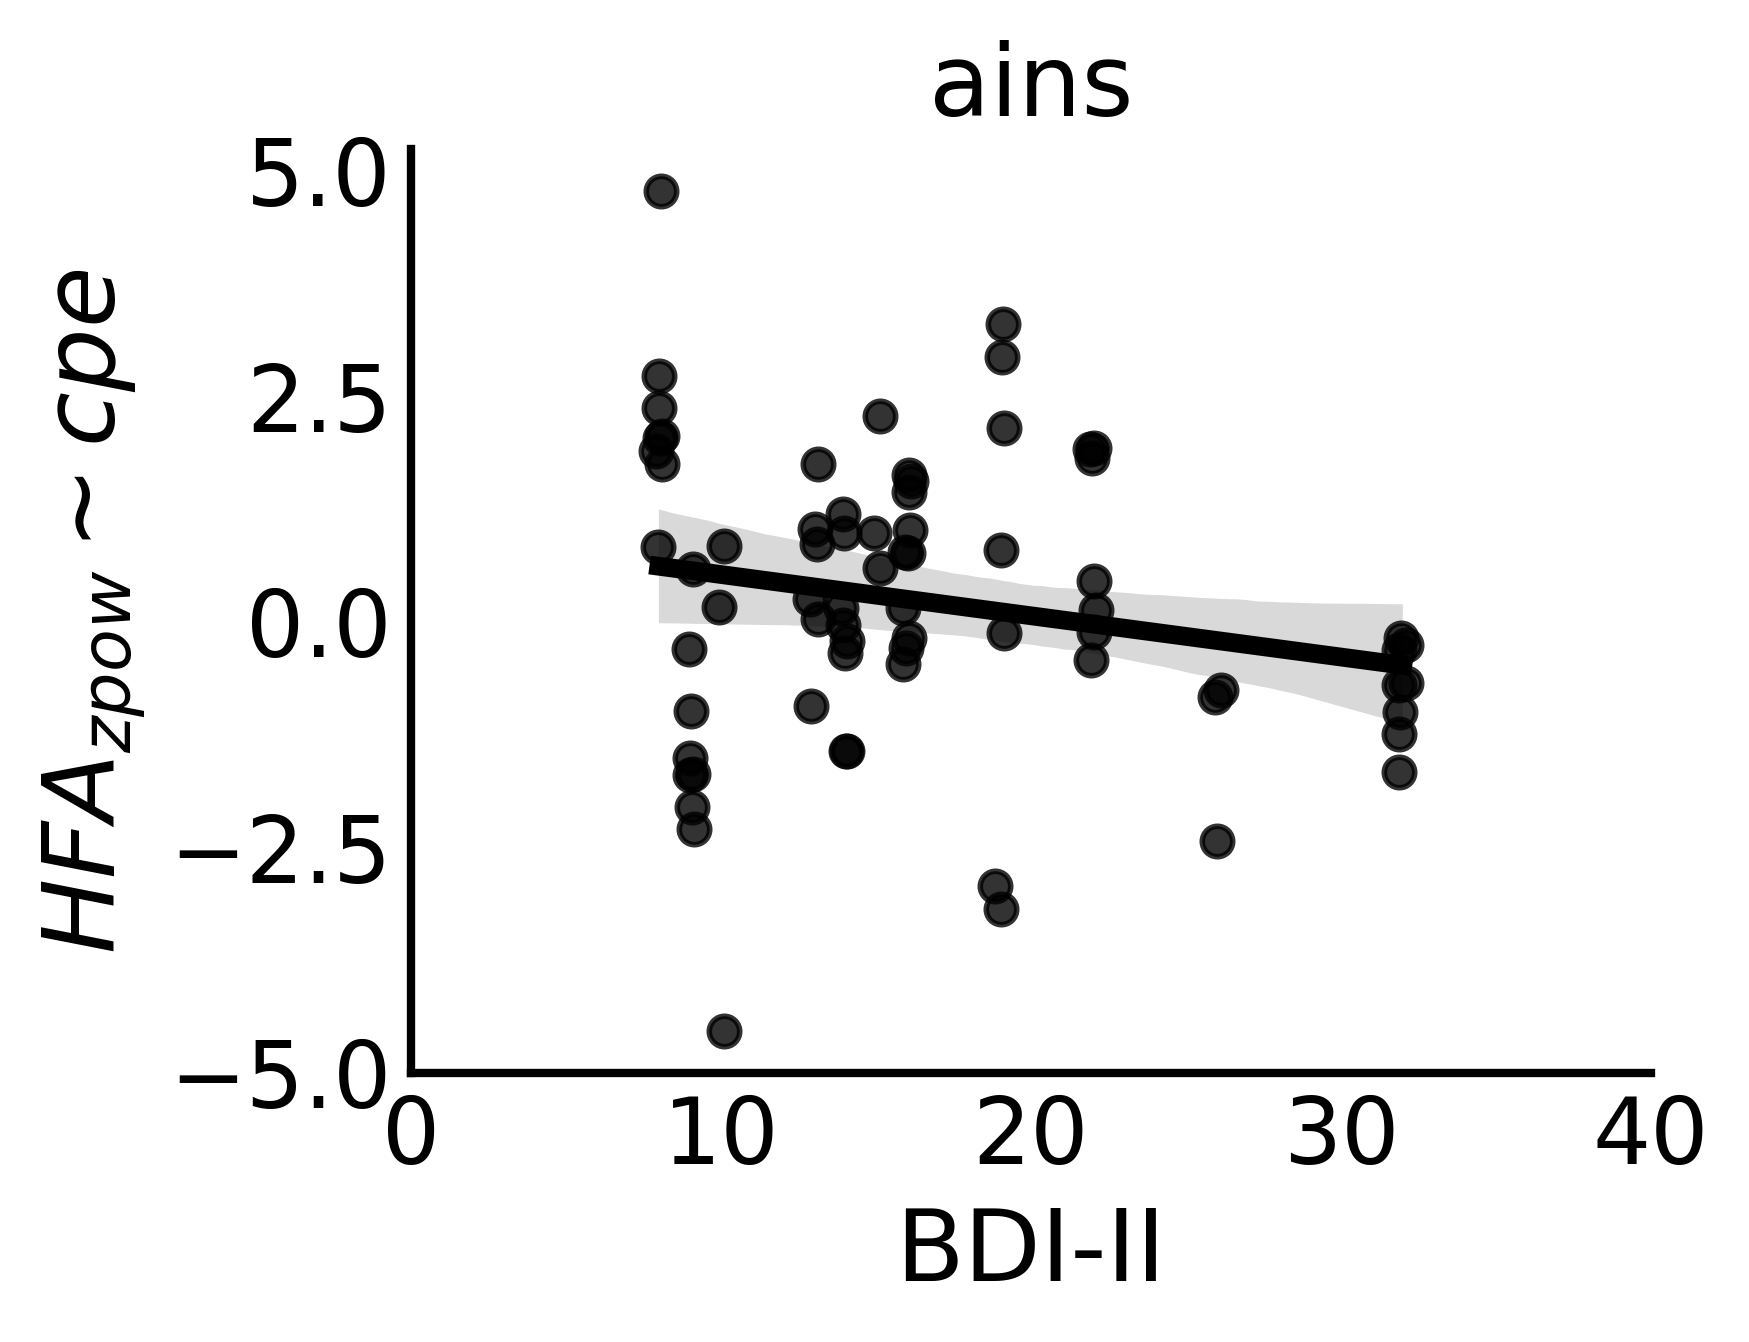

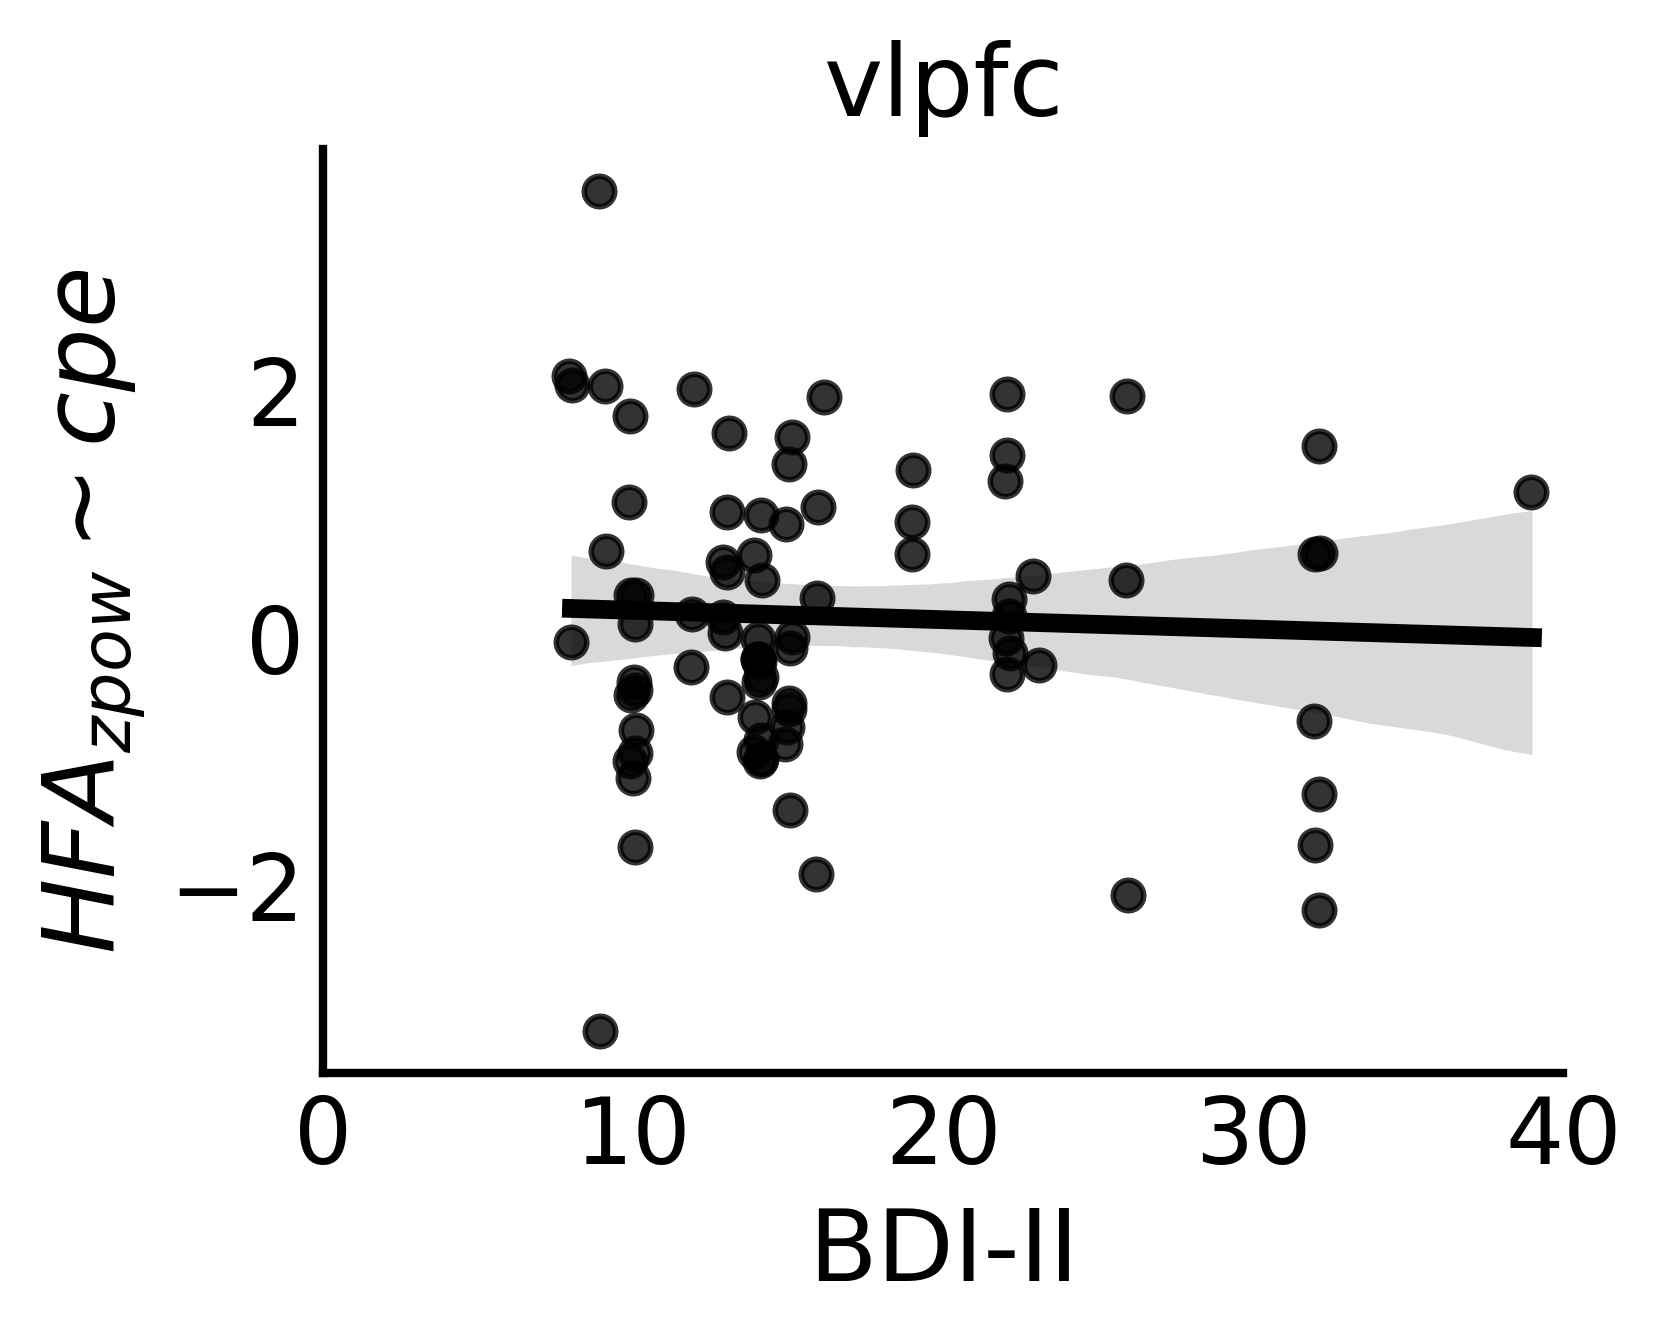

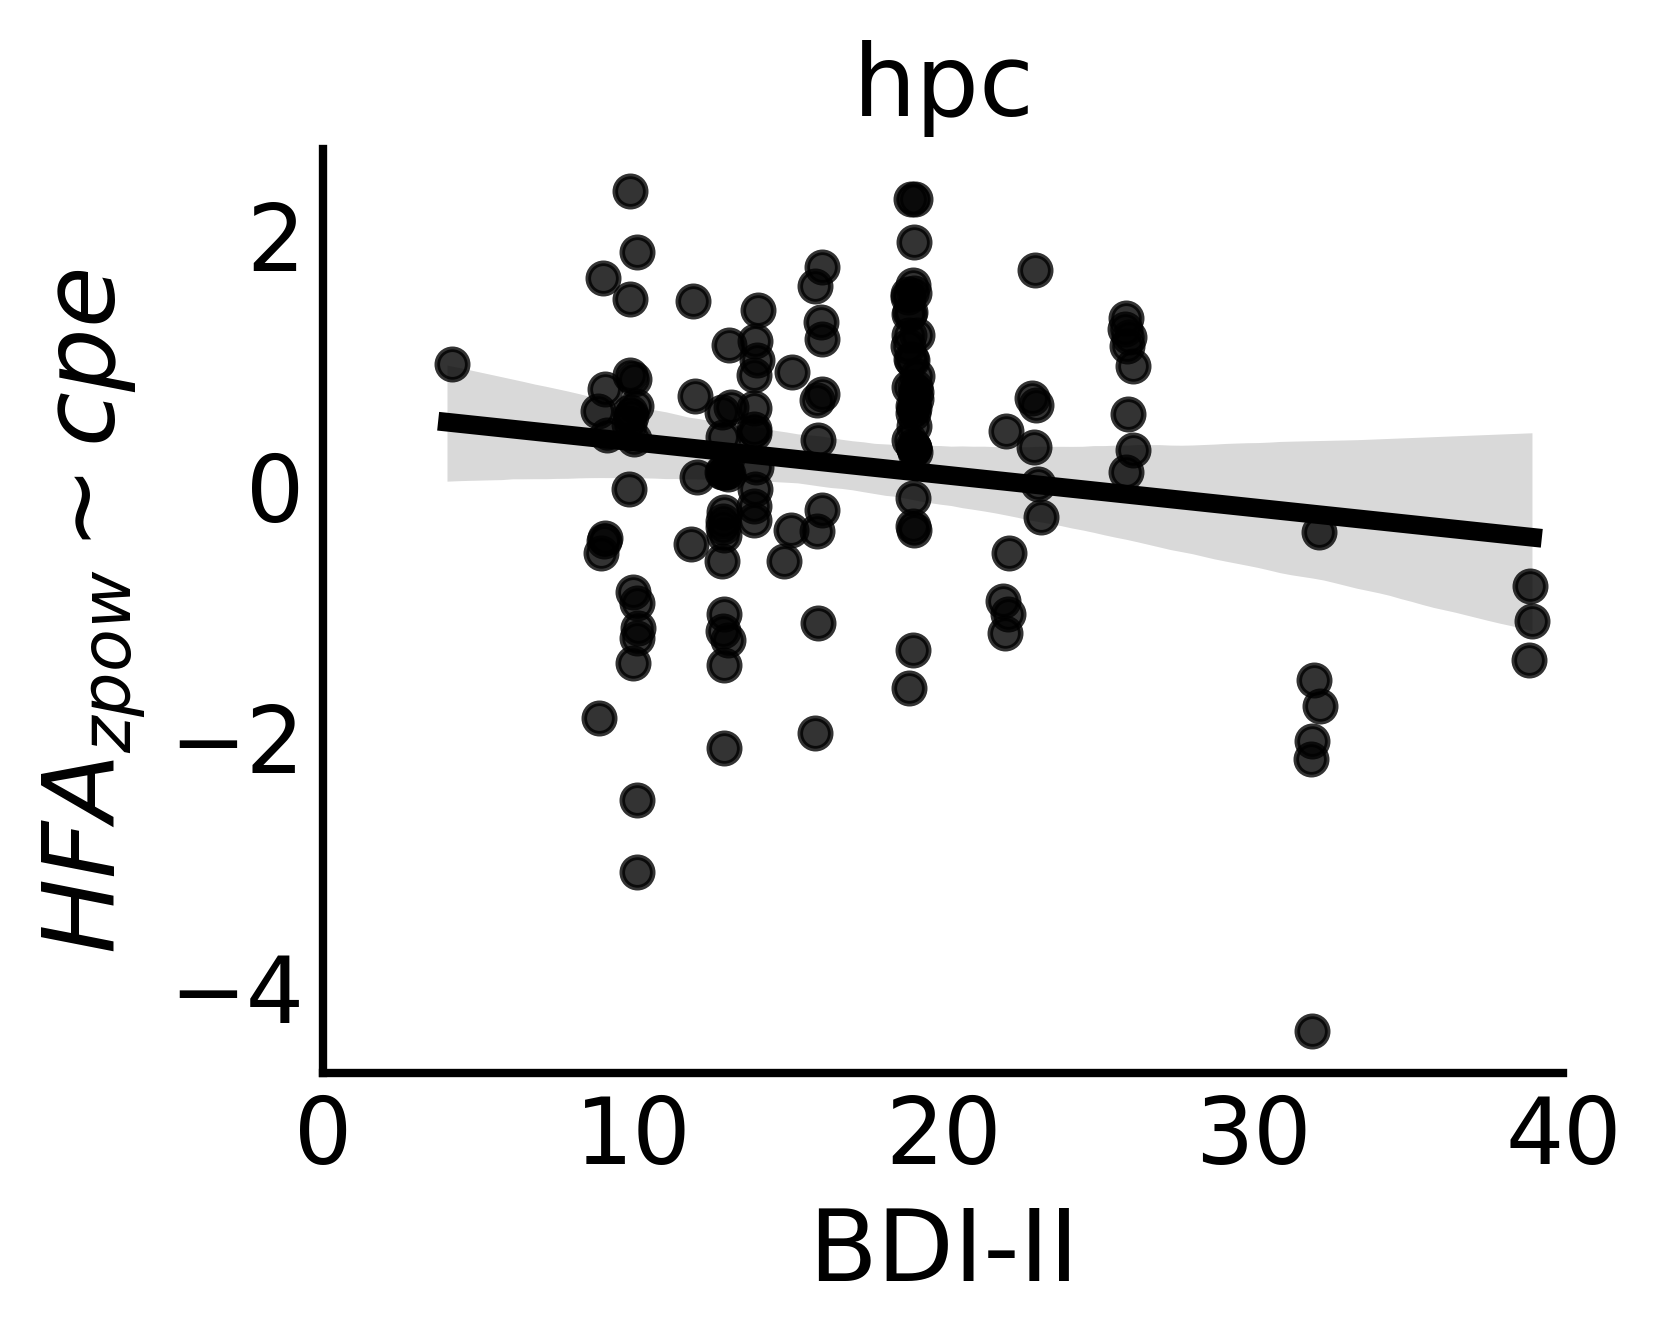

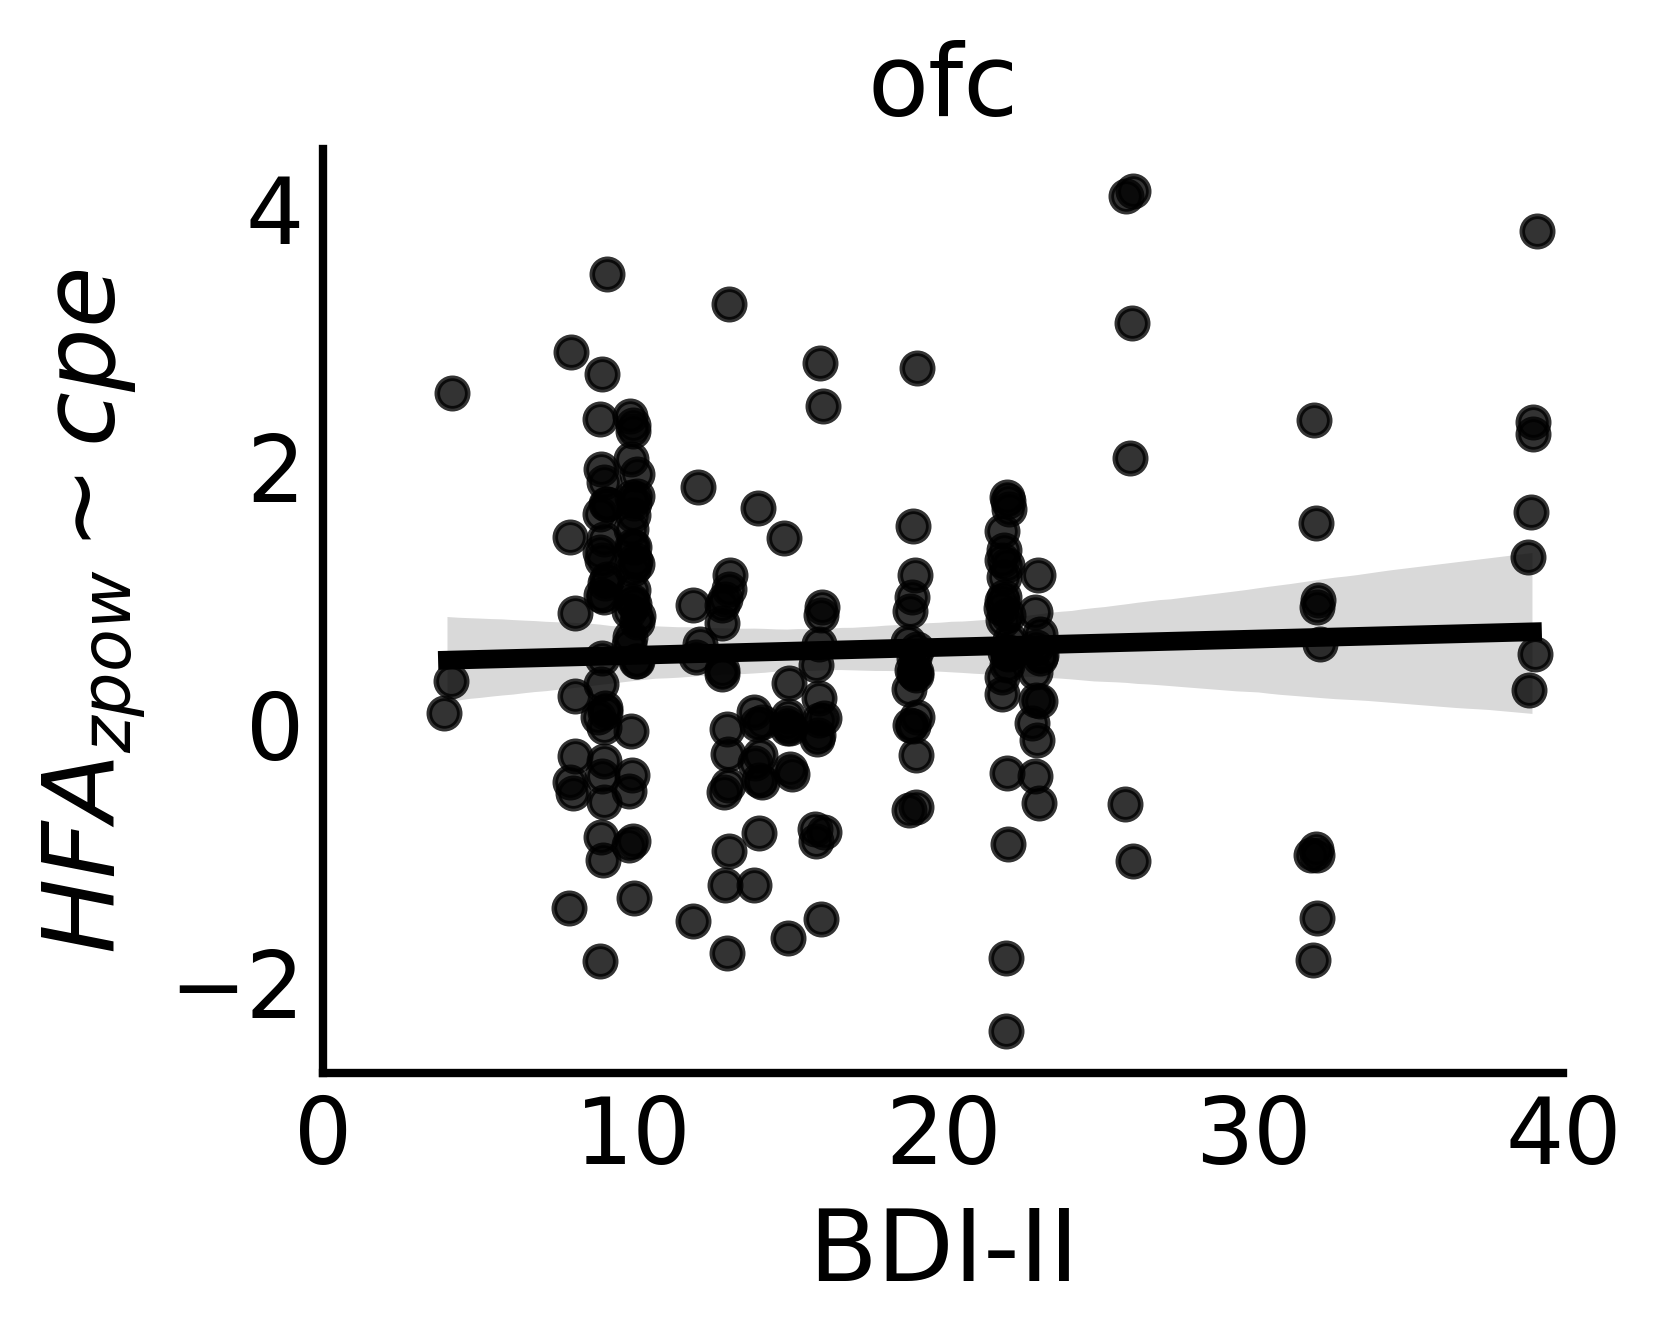

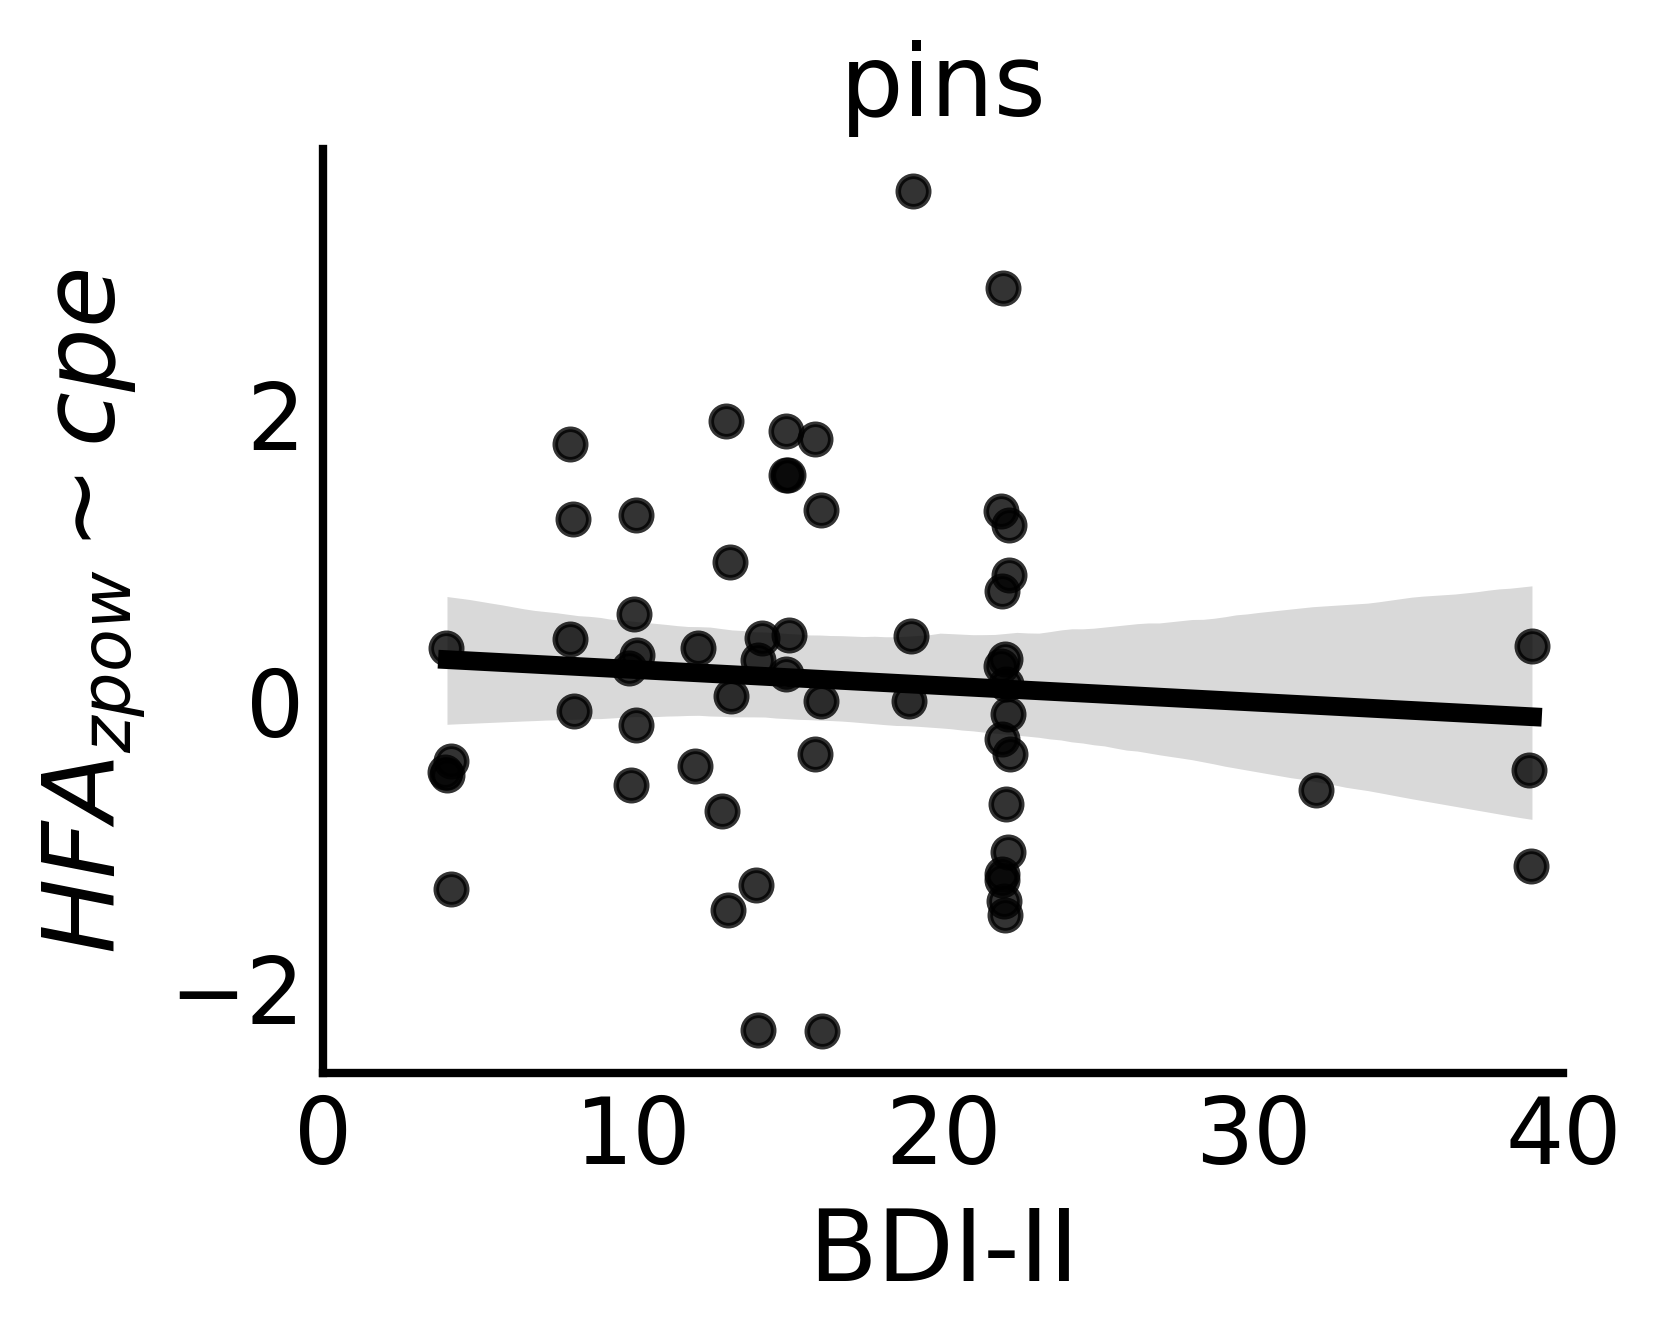

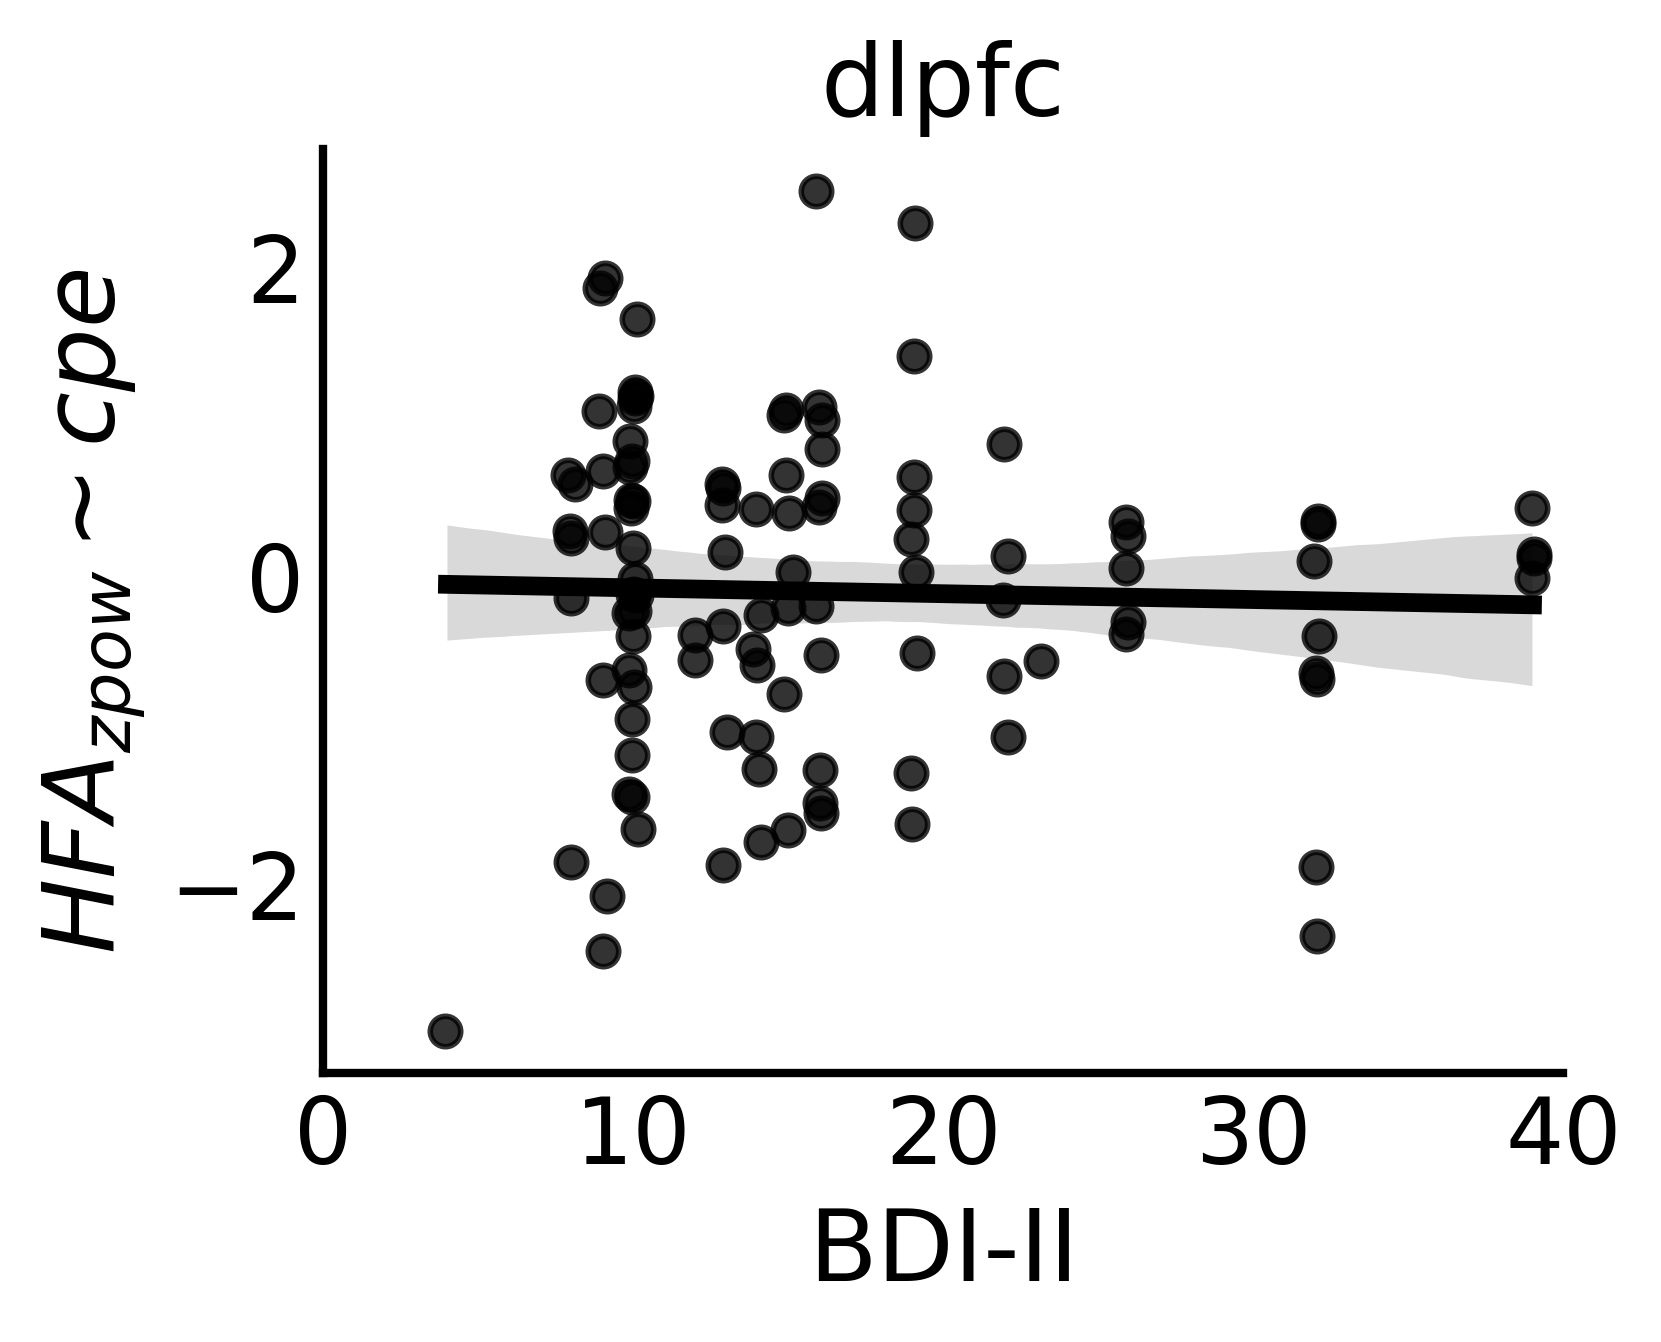

In [29]:
sns.set_context("talk",rc={'axes.linewidth': 1.5})

for roi in single_elec_res.roi.unique().tolist():
    corr_fig_id = f'{band}_{roi}_bdi_cpe_coeff_scatter.pdf'
    roi_temp_data = single_elec_res[single_elec_res.roi==roi]
        
    fig,ax = plt.subplots(1,1,figsize=(4,3),dpi=400)

    sns.regplot(data=roi_temp_data,x='bdi',y='Z_Score_decisionCPE',scatter=True,ci=95,
                fit_reg=True,color = 'k',x_jitter = 0.15,scatter_kws={'s':30}) #034975
    
    plt.xlabel('BDI-II')
    plt.xlim([0,40])
    
    plt.tick_params(length=0) 
    plt.ylabel(fr'$HFA_{{zpow}} \sim cpe$')
    
    plt.title(f'{roi}')
    sns.despine()

    plt.savefig(f'{fig_save_dir}{corr_fig_id}', format=corr_fig_id.split('.')[-1], metadata=None,
        bbox_inches='tight', pad_inches=0.1,dpi=400,
        facecolor='auto', edgecolor='auto',
        backend=None)


### Test BDI Correlations via robust regression

In [30]:
### robust regression bdi ~ cpe coefficients
roi_rlm_dict = {}

for roi in single_elec_res.roi.unique().tolist():
    roi_df = single_elec_res[single_elec_res.roi == roi]
    rlm = sm.RLM(roi_df.bdi.values, sm.add_constant(roi_df.Z_Score_decisionCPE.values), M=sm.robust.norms.HuberT())
    rlm_results = rlm.fit()
    roi_rlm_dict[roi] = rlm_results
    print(roi)
    print(rlm_results.summary())




acc
                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                  193
Model:                            RLM   Df Residuals:                      191
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Thu, 22 Aug 2024                                         
Time:                        20:06:56                                         
No. Iterations:                    12                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.1390      0.473     34.120     

# Mixed effects models

In [31]:
outcome_var  = 'band_pow'
rand_eff_var = 'unique_reref_ch'
reg_vars     = ['GambleChoice','TotalProfit', 'decisionCPE','roi','hemi','bdi','bdi:decisionCPE']
rand_vars    = ['GambleChoice','TotalProfit', 'decisionCPE']


In [32]:
roi_fit_dict = {f'{roi}':fit_mixed_model(hfa_reg_df[hfa_reg_df.roi==roi],
                                        reg_vars,rand_vars,outcome_var,rand_eff_var) 
                for roi in hfa_reg_df.roi.unique().tolist()}

roi_fit_results = []

for roi in list(roi_fit_dict.keys()):
    roi_fit = mixed_eff_results_df(roi_fit_dict[roi],hfa_reg_df[hfa_reg_df.roi==roi])
    roi_fit_results.append(roi_fit)
    
roi_fit_results = pd.concat(roi_fit_results).reset_index(drop=True)


In [33]:
roi_fit_results['band'] = band
roi_fit_results.to_csv(f'{save_dir}{band}_roi_reg_results.csv')

# raw_roi_stats = {f'{roi}':ttest_1samp(roi_fit_results.decisionCPE[roi_fit_results.roi == roi].unique(),
#                  popmean=0) for roi in roi_fit_results.roi.unique().tolist()}
# raw_roi_stats

In [34]:
# roi_fit_results

fe_params_results = {f'{roi}':roi_fit_dict[roi].fe_params for roi in list(roi_fit_dict.keys())}
fe_results = []
for fe_res in fe_params_results:
    fe_results.append(pd.DataFrame({**dict(fe_params_results[fe_res]),**{'roi':fe_res}},index=[0]))
    
fe_results = pd.concat(fe_results).reset_index(drop=True)
fe_results['cpe_pval'] = [np.round(roi_fit_dict[roi].pvalues['decisionCPE'],4) for roi in fe_results.roi.tolist()]
fe_results['bdi_pval'] = [np.round(roi_fit_dict[roi].pvalues['bdi'],4) for roi in fe_results.roi.tolist()]
fe_results['cpe_bdi_pval'] = [np.round(roi_fit_dict[roi].pvalues['bdi:decisionCPE'],4) for roi in fe_results.roi.tolist()]

fe_results


,Intercept,GambleChoice[T.safe],hemi[T.r],TotalProfit,decisionCPE,bdi,bdi:decisionCPE,roi,cpe_pval,bdi_pval,cpe_bdi_pval
0,-0.001170,-0.006725,0.003880,-0.016278,0.011847,-0.000211,-0.000353,acc,0.0004,0.1798,0.0604
1,-0.011717,0.002905,0.009401,-0.015918,0.005843,0.000052,-0.000285,dmpfc,0.0718,0.8302,0.1116
2,-0.011194,0.004100,-0.003365,0.004985,0.018018,-0.000703,-0.000786,amy,0.0001,0.1369,0.0024
3,0.010936,0.000427,0.011294,0.001492,0.013960,-0.000753,-0.000628,ains,0.0535,0.1488,0.1184
4,-0.015014,0.008152,-0.001037,-0.012118,0.006527,0.000544,-0.000196,vlpfc,0.3438,0.3994,0.6144
5,-0.118569,0.006704,-0.017159,0.000568,0.013542,0.003443,-0.000727,hpc,0.0083,0.0135,0.0092
6,0.004837,0.013501,-0.014745,-0.011378,0.009104,-0.001022,0.000083,ofc,0.0217,0.0655,0.7014
7,-0.072810,-0.001643,0.047446,0.008999,0.005200,-0.000439,-0.000261,pins,0.4858,0.8350,0.5236
8,-0.003768,0.016253,-0.006951,-0.011643,-0.000470,-0.000479,0.000116,dlpfc,0.9364,0.2963,0.7108


In [35]:
fe_results.set_index('roi')

,Intercept,GambleChoice[T.safe],hemi[T.r],TotalProfit,decisionCPE,bdi,bdi:decisionCPE,cpe_pval,bdi_pval,cpe_bdi_pval
roi,,,,,,,,,,
acc,-0.001170,-0.006725,0.003880,-0.016278,0.011847,-0.000211,-0.000353,0.0004,0.1798,0.0604
dmpfc,-0.011717,0.002905,0.009401,-0.015918,0.005843,0.000052,-0.000285,0.0718,0.8302,0.1116
amy,-0.011194,0.004100,-0.003365,0.004985,0.018018,-0.000703,-0.000786,0.0001,0.1369,0.0024
ains,0.010936,0.000427,0.011294,0.001492,0.013960,-0.000753,-0.000628,0.0535,0.1488,0.1184
vlpfc,-0.015014,0.008152,-0.001037,-0.012118,0.006527,0.000544,-0.000196,0.3438,0.3994,0.6144
hpc,-0.118569,0.006704,-0.017159,0.000568,0.013542,0.003443,-0.000727,0.0083,0.0135,0.0092
ofc,0.004837,0.013501,-0.014745,-0.011378,0.009104,-0.001022,0.000083,0.0217,0.0655,0.7014
pins,-0.072810,-0.001643,0.047446,0.008999,0.005200,-0.000439,-0.000261,0.4858,0.8350,0.5236
dlpfc,-0.003768,0.016253,-0.006951,-0.011643,-0.000470,-0.000479,0.000116,0.9364,0.2963,0.7108


In [36]:
bonferr_alpha = 0.05/len(fe_results)
# bonferr_alpha = 0.01

bonferr_alpha



0.005555555555555556

In [37]:
sig_cpe_rois = fe_results.roi[fe_results.cpe_pval <= bonferr_alpha].tolist()
sig_cpe_rois



['acc', 'amy']

In [38]:
sig_cpe_bdi_rois = fe_results.roi[fe_results.cpe_bdi_pval <= bonferr_alpha].tolist()
sig_cpe_bdi_rois



['amy']

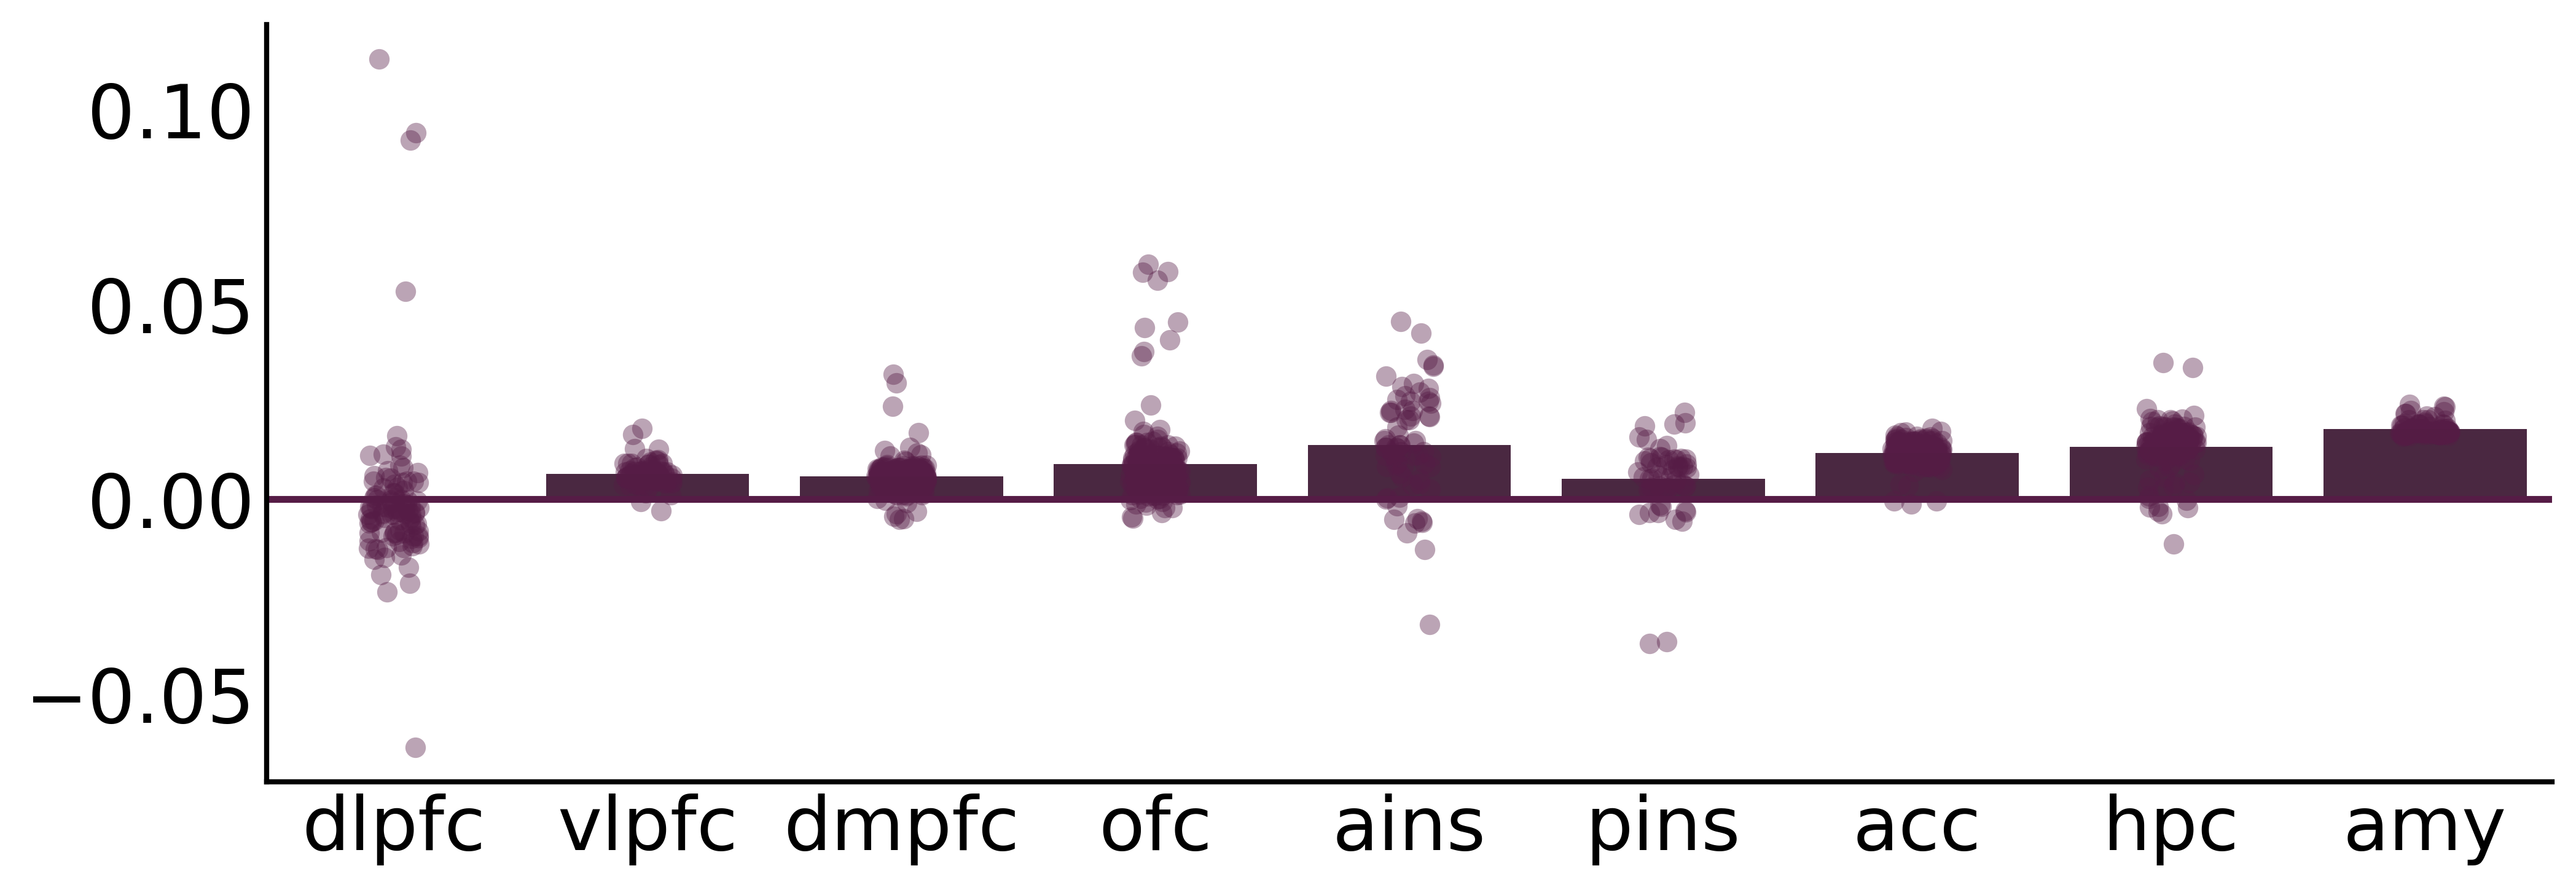

In [39]:
plot_roi_model_results(roi_fit_results,'roi','decisionCPE',bar_order=bar_order,figsize=(12,4),color='#561C46')


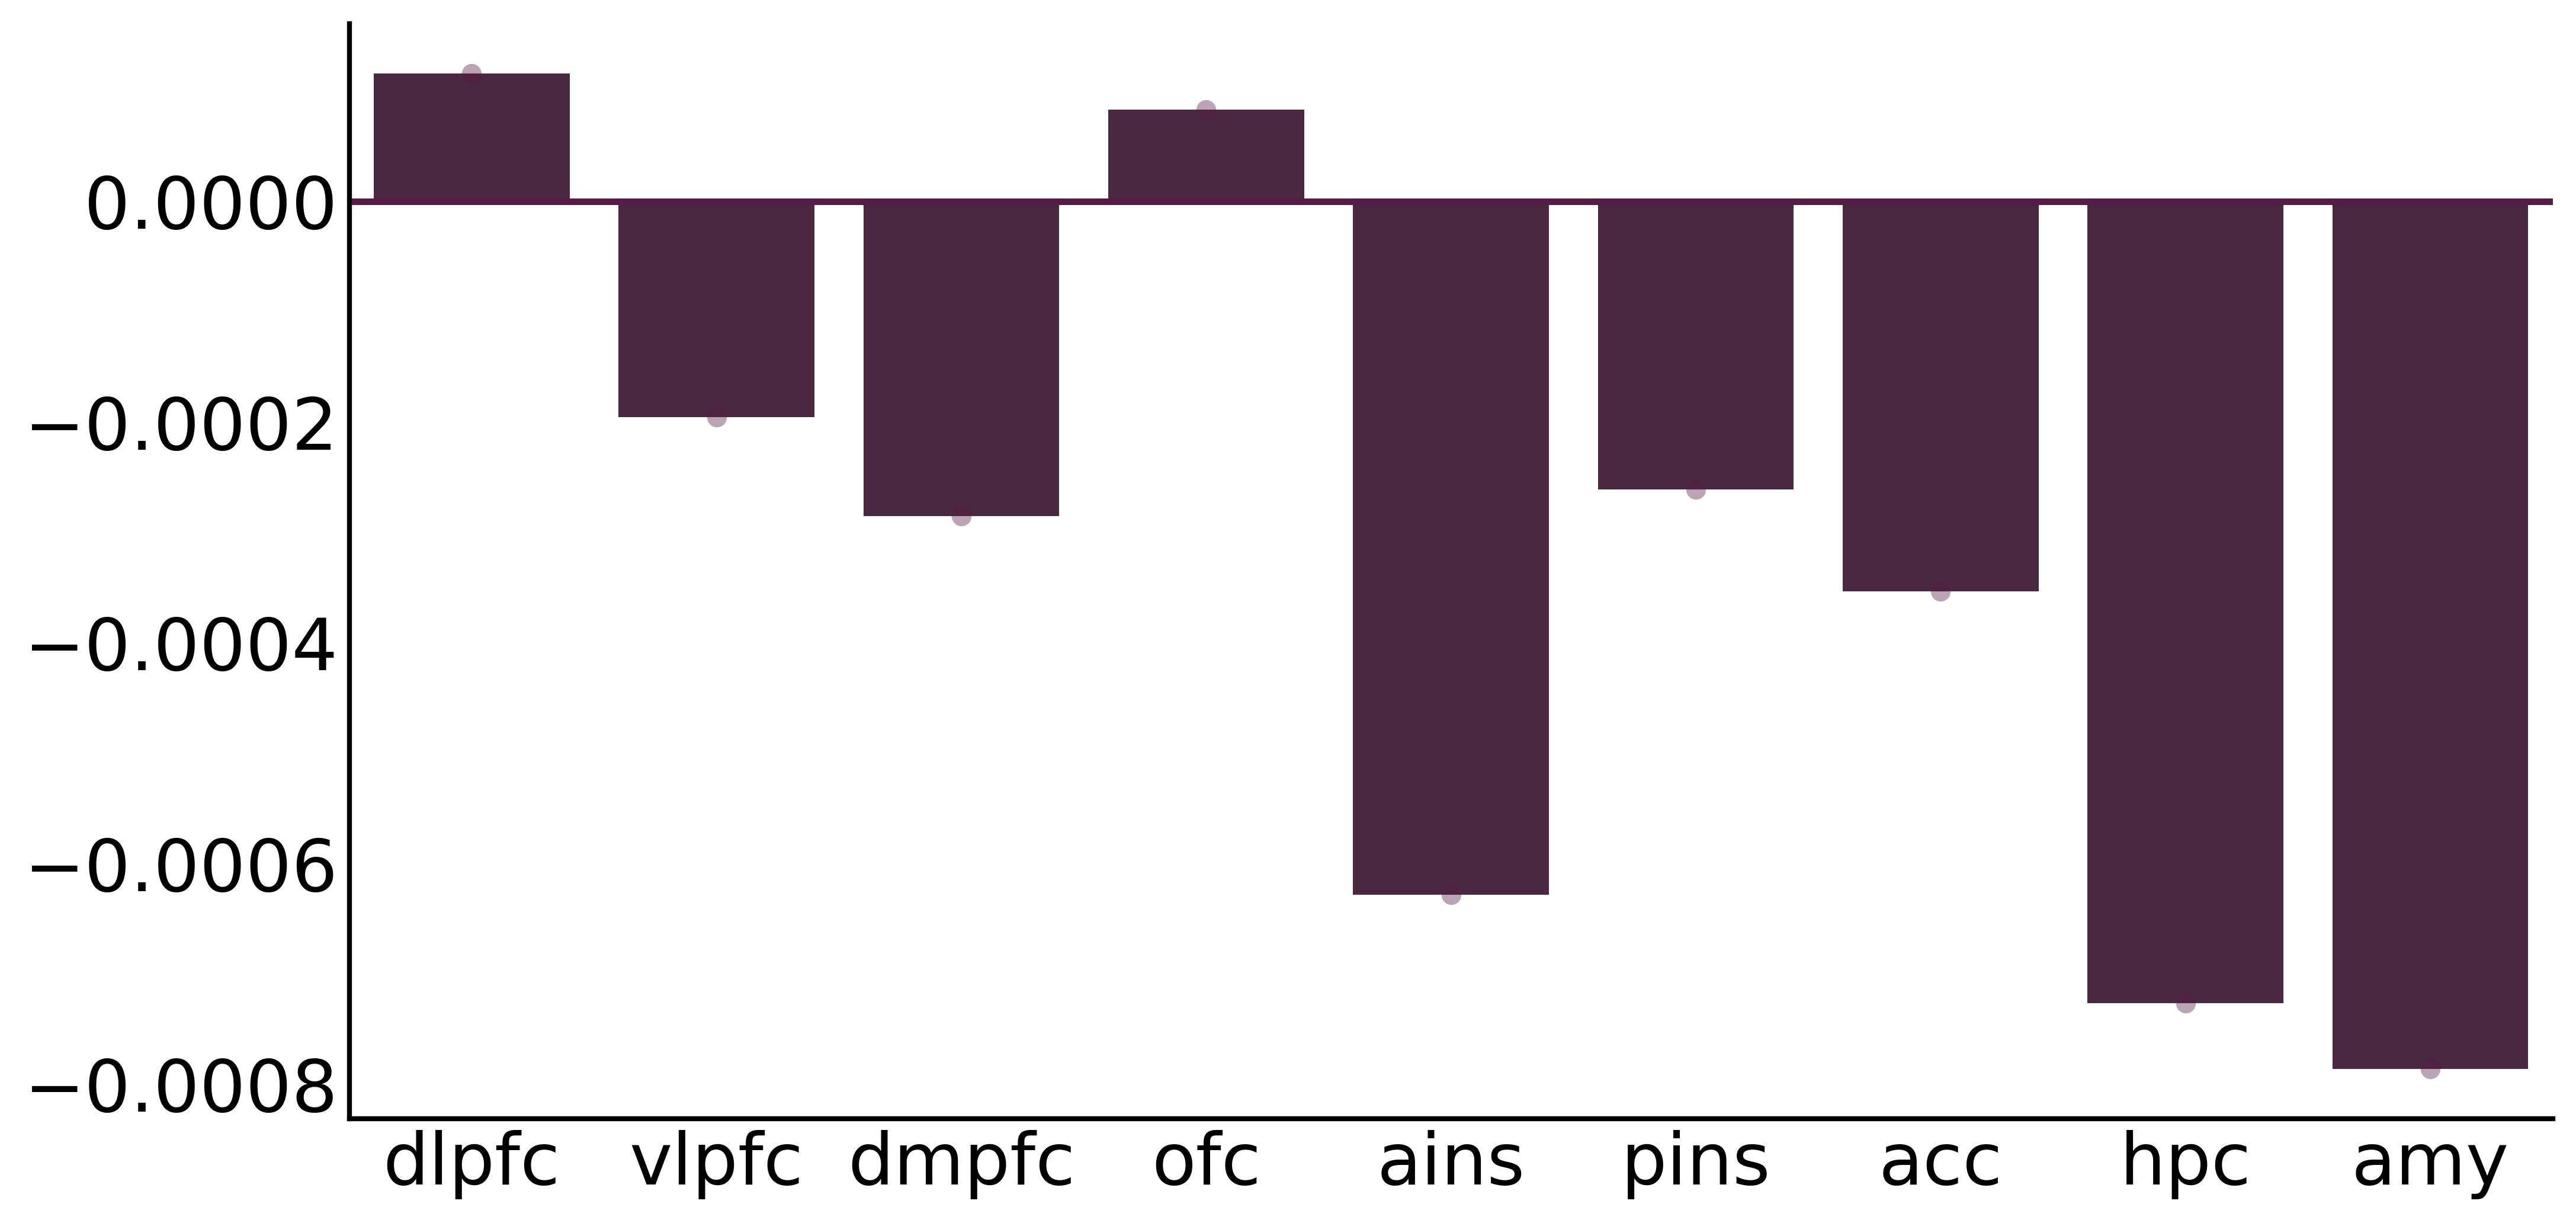

In [41]:
plot_roi_model_results(fe_results,'roi',"bdi:decisionCPE",bar_order=bar_order,figsize=(12,6),color='#561C46')
# add to slides 
